# Clasificación según distribución de $PM_{2.5}/PM_{10}$

En este código se realiza la clasificación de los datos según la distribución de $PM_{2.5}/PM_{10}$, clasificación propuesta en el artículo de [Fan, H., Zhao, C., Yang, Y., & Yang, X. (2021)](https://doi.org/10.3389/fenvs.2021.692440). Para esto, se utilizarán los datos de las estaciones de monitoreo de Bogotá del año 2022. De estos se hallará el valor del pico, la kurtosis y la asimetría de la distribución de $PM_{2.5}/PM_{10}$ para cada estación. La clasificación se realizará según los siguientes criterios:  
![Clasificación de los contaminantes](../img/clasificacion_pm_ratio.jpg) 

In [1]:
# importamos las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import timedelta
import bs4 as bs
import requests
import re

## 1. Importación de datos

### Definición y ejecución función de importación

Importación todos los datos de las estaciones de monitoreo de Bogotá

In [3]:
# array con los nombres código de las estaciones
estaciones = ["BOL","CBV","CDAR","COL","CSE","FTB",
              "GYR","JAZ","KEN","LFR","MAM","MOV1",
              "MOV2","PTE","SCR","SUB","TUN","USM","USQ"]

# definimos la función para importar los datos de las estaciones
def importar_datos_individuales(estaciones, año, col_names=["PM10", "PM2.5"], carpeta="PM"):
    # importamos los datos de las estaciones y cada DataFrame lo guardamos en un diccionario
    datos = {}
    for i in estaciones:
        # importamos un set de datos
        data = pd.read_excel(
            "../data/"+str(año)+"/"+str(carpeta)+"/" + str(i) + "_"+str(año)+".xlsx", skiprows=3, skipfooter=11, index_col=0
        )[col_names] # importamos las columnas requeridas

        # eliminamos la fila de unidades
        data.drop(data.index[0], inplace=True)

        # cambiamos el indice a tipo fecha, cambiando el 24:00 por 00:00 del otro día
        data.index = pd.to_datetime(
            data.index.str.replace("24:00", "00:00"), format="%d-%m-%Y %H:%M"
        )
        new_index = []
        for j in range(len(data.index)):
            new_index.append(data.index[j])
            if data.index[j].hour == 0:  # si la hora es 00:00 le sumamos un día
                new_index[j] = data.index[j] + timedelta(days=1)
        data.index = new_index

        # cambiamos el tipo de datos a float
        for k in col_names:
            data[k] = pd.to_numeric(data[k], errors="coerce")
        
        # eliminamos los datos nulos
        data.dropna(inplace=True)

        if carpeta == "PM":
            # creamos la columna con la relacion PM2.5/PM10
            data["ratio"] = data["PM2.5"] / data["PM10"]

            # eliminamos todas las entradas en las que el ratio es mayor o igual a 1 y menor o igual a 0
            data = data[data["ratio"] < 1]
            data = data[data["ratio"] > 0]

        # guardamos el DataFrame con su nombre en el diccionario
        datos[i] = data

    # calculamos el procentaje de datos que tenemos en cada estacion: datos validos/8760 (8760 horas en un año)
    porcentaje_datos = {}
    for i in estaciones:
        porcentaje_datos[i] = len(datos[i]) / 8760

    # # descartamos las estaciones que tienen menos del 70% de datos validos
    # estaciones = [i for i in estaciones if porcentaje_datos[i] >= 0.7]
    # datos = {i: datos[i] for i in estaciones}

    return datos, porcentaje_datos

In [4]:
# importamos los datos de las estaciones para cada año
datos_2018, porcentaje_datos_2018 = importar_datos_individuales(estaciones, 2018) #new
datos_2019, porcentaje_datos_2019 = importar_datos_individuales(estaciones, 2019) #new
datos_2020, porcentaje_datos_2020 = importar_datos_individuales(estaciones, 2020)
datos_2021, porcentaje_datos_2021 = importar_datos_individuales(estaciones, 2021)
datos_2022, porcentaje_datos_2022 = importar_datos_individuales(estaciones, 2022)

Visualización de los porcentajes de datos respecto a los de un año y respecto a todo el periodo

In [5]:
# imprimimos el porcentaje de datos validos de cada estacion
print("Porcentaje de datos validos en 2018 -> 2019 -> 2020 -> 2021 -> 2022 -> [2018-2022]:")
tot_periodo = {}
for i, estacion in enumerate(estaciones):
    tot_periodo[estacion] = (porcentaje_datos_2018[estacion]+porcentaje_datos_2019[estacion]+porcentaje_datos_2020[estacion]+porcentaje_datos_2021[estacion]+porcentaje_datos_2022[estacion])/5*100
    print(f"{i+1}. {estacion}: {porcentaje_datos_2018[estacion]*100:.2f}% -> {porcentaje_datos_2019[estacion]*100:.2f}% -> {porcentaje_datos_2020[estacion]*100:.2f}% -> {porcentaje_datos_2021[estacion]*100:.2f}% -> {porcentaje_datos_2022[estacion]*100:.2f}% -> {tot_periodo[estacion]:.2f}%")

Porcentaje de datos validos en 2018 -> 2019 -> 2020 -> 2021 -> 2022 -> [2018-2022]:
1. BOL: 0.00% -> 0.00% -> 18.97% -> 95.09% -> 84.37% -> 39.69%
2. CBV: 0.00% -> 0.00% -> 20.08% -> 93.64% -> 92.28% -> 41.20%
3. CDAR: 77.07% -> 84.97% -> 75.68% -> 71.68% -> 81.91% -> 78.26%
4. COL: 0.00% -> 0.00% -> 0.00% -> 67.11% -> 88.07% -> 31.04%
5. CSE: 84.66% -> 80.82% -> 89.42% -> 79.62% -> 19.10% -> 70.72%
6. FTB: 6.63% -> 93.64% -> 86.74% -> 81.91% -> 94.24% -> 72.63%
7. GYR: 78.76% -> 90.08% -> 81.36% -> 83.64% -> 91.11% -> 84.99%
8. JAZ: 0.00% -> 0.00% -> 22.60% -> 91.91% -> 93.38% -> 41.58%
9. KEN: 93.77% -> 91.83% -> 92.81% -> 86.70% -> 83.42% -> 89.71%
10. LFR: 79.18% -> 79.60% -> 76.07% -> 75.55% -> 84.32% -> 78.94%
11. MAM: 74.47% -> 92.57% -> 72.68% -> 70.96% -> 75.02% -> 77.14%
12. MOV1: 48.71% -> 68.20% -> 91.96% -> 81.48% -> 54.75% -> 69.02%
13. MOV2: 0.00% -> 0.00% -> 0.00% -> 68.25% -> 92.98% -> 32.25%
14. PTE: 83.62% -> 65.62% -> 81.64% -> 58.09% -> 40.10% -> 65.82%
15. SCR: 84

Eliminación de los datos cuyo porcentaje es menor al 70%

In [5]:
print(datos_2022.keys())

dict_keys(['BOL', 'CBV', 'CDAR', 'COL', 'CSE', 'FTB', 'GYR', 'JAZ', 'KEN', 'LFR', 'MAM', 'MOV1', 'MOV2', 'PTE', 'SCR', 'SUB', 'TUN', 'USM', 'USQ'])


In [6]:
# en cada grupo de datos por año, eliminamos las estaciones con menos del 70% de datos validos
#solo ejecutar una vez :p
estaciones_periodo = [i for i in estaciones if tot_periodo[i] >= 70]
datos_periodo = {i: pd.concat([datos_2018[i], datos_2019[i], datos_2020[i], datos_2021[i], datos_2022[i]]) for i in estaciones_periodo}

estaciones_2018 = [i for i in estaciones if porcentaje_datos_2018[i] >= 0.7] #new
datos_2018 = {i: datos_2018[i] for i in estaciones_2018} #new
estaciones_2019 = [i for i in estaciones if porcentaje_datos_2019[i] >= 0.7] #new
datos_2019 = {i: datos_2019[i] for i in estaciones_2019} #new
estaciones_2020 = [i for i in estaciones if porcentaje_datos_2020[i] >= 0.7]
datos_2020 = {i: datos_2020[i] for i in estaciones_2020}
estaciones_2021 = [i for i in estaciones if porcentaje_datos_2021[i] >= 0.7]
datos_2021 = {i: datos_2021[i] for i in estaciones_2021}
estaciones_2022 = [i for i in estaciones if porcentaje_datos_2022[i] >= 0.7]
datos_2022 = {i: datos_2022[i] for i in estaciones_2022}

# imprimimos la cantidad de estaciones en cada año
print("\nCantidad de estaciones en 2018 -> 2019 ->  2020 -> 2021 -> 2022 -> [2018-2022]:")
print(f"{len(estaciones_2018)} -> {len(estaciones_2019)} -> {len(estaciones_2020)} -> {len(estaciones_2021)} -> {len(estaciones_2022)} -> {len(estaciones_periodo)}")



Cantidad de estaciones en 2018 -> 2019 ->  2020 -> 2021 -> 2022 -> [2018-2022]:
11 -> 10 -> 12 -> 14 -> 16 -> 10


### Lista de porcentajes de datos de cada estación

Estaciones que cumplen con el porcentaje de datos en cada año

In [7]:
print("Estaciones con más del 70% de datos validos:")
for i, estacion in enumerate(estaciones_2018):
    print(f"{i+1}. {estacion} - {porcentaje_datos_2018[estacion]*100:.2f}%")

print("Estaciones con más del 70% de datos validos:")
for i, estacion in enumerate(estaciones_2019):
    print(f"{i+1}. {estacion} - {porcentaje_datos_2019[estacion]*100:.2f}%")

print("Estaciones con más del 70% de datos validos:")
for i, estacion in enumerate(estaciones_2020):
    print(f"{i+1}. {estacion} - {porcentaje_datos_2020[estacion]*100:.2f}%")

print("\nEstaciones con más del 70% de datos validos:")
for i, estacion in enumerate(estaciones_2021):
    print(f"{i+1}. {estacion} - {porcentaje_datos_2021[estacion]*100:.2f}%")

print("\nEstaciones con más del 70% de datos validos:")
for i, estacion in enumerate(estaciones_2022):
    print(f"{i+1}. {estacion} - {porcentaje_datos_2022[estacion]*100:.2f}%")

Estaciones con más del 70% de datos validos:
1. CDAR - 77.07%
2. CSE - 84.66%
3. GYR - 78.76%
4. KEN - 93.77%
5. LFR - 79.18%
6. MAM - 74.47%
7. PTE - 83.62%
8. SCR - 84.87%
9. SUB - 91.31%
10. TUN - 83.48%
11. USQ - 86.29%
Estaciones con más del 70% de datos validos:
1. CDAR - 84.97%
2. CSE - 80.82%
3. FTB - 93.64%
4. GYR - 90.08%
5. KEN - 91.83%
6. LFR - 79.60%
7. MAM - 92.57%
8. SUB - 91.40%
9. TUN - 91.40%
10. USQ - 75.22%
Estaciones con más del 70% de datos validos:
1. CDAR - 75.68%
2. CSE - 89.42%
3. FTB - 86.74%
4. GYR - 81.36%
5. KEN - 92.81%
6. LFR - 76.07%
7. MAM - 72.68%
8. MOV1 - 91.96%
9. PTE - 81.64%
10. SCR - 80.31%
11. SUB - 85.11%
12. TUN - 91.56%

Estaciones con más del 70% de datos validos:
1. BOL - 95.09%
2. CBV - 93.64%
3. CDAR - 71.68%
4. CSE - 79.62%
5. FTB - 81.91%
6. GYR - 83.64%
7. JAZ - 91.91%
8. KEN - 86.70%
9. LFR - 75.55%
10. MAM - 70.96%
11. MOV1 - 81.48%
12. SUB - 83.42%
13. TUN - 84.92%
14. USM - 91.07%

Estaciones con más del 70% de datos validos:
1. B

## 2. Clasificación de contaminantes por en cada estación

### Definición de constantes y funciones

Definimos las funciones de graficación de los histogramas, de clasificación de los contaminantes y de mapeado sobre el mapa de Bogotá

In [9]:
# definimos las constantes

lim_inf = 0.4  # limites de clasificación y el numero de bins
lim_sup = 0.6
n_bins = "doane" # metodo de calculo de los bins

tipos = {      # tipos de contaminantes
    1.1: "Typical Dust type (Ia)",
    1.2: "Atypical Dust type (Ib)",
    2.1: "Typical Mixed type (IIa)",
    2.21: "Mixed-Anthropogenic type (IIb1)",
    2.22: "Mixed-Dust type (IIb2)",
    3.1: "Typical Anthropogenic type (IIIa)",
    3.2: "Atypical Anthropogenic type (IIIb)",
}

url = "https://ambientebogota.gov.co/estaciones-rmcab" # url de la pagina de la RMCAB


colores = {     # colores para cada tipo de contaminante en el mapa
    1.1: "saddlebrown",
    1.2: "chocolate",
    2.1: "black",
    2.21: "midnightblue",
    2.22: "mediumpurple",
    3.1: "#e40000",
    3.2: "#ff4c4c",
}

# definimos la función para graficar los histogramas
def graficar_histogramas(datos, estaciones, año):
    # graficamos el histograma de la relacion PM2.5/PM10 para cada estacion
    fig, ax = plt.subplots(4, np.ceil(len(estaciones)/4).astype("int"), figsize=(17, 12))
    ax = ax.ravel()  # convertimos el array de 4x4 a 1x16

    for i in range(len(estaciones)):
        ax[i].hist(
            datos[estaciones[i]]["ratio"],
            bins=n_bins,
            edgecolor="black",
            histtype="bar",
            color="darkorchid",
            align="mid",
            range=(0, 1),
        )
        ax[i].axvline(lim_inf, color="red", linestyle="dashed")
        ax[i].axvline(lim_sup, color="red", linestyle="dashed")
        ax[i].set_title(estaciones[i], fontsize=15, fontweight="bold")
        ax[i].grid(alpha=0.5)
        ax[i].set_axisbelow(True)  # para que la grilla quede detras de las barras
        ax[i].tick_params(
            axis="both", which="major", labelsize=11, length=4
        )  # tamaño de los numeros en los ejes

    # agregamos espacio entre los subplots
    fig.subplots_adjust(hspace=0.3, wspace=0.15, left=0.08)

    # agregamos un solo texto centrado en la parte inferior
    fig.text(0.5, 0.05, r"$PM_{2.5}/PM_{10}$ "+str(año), ha="center", fontsize=22)

    # agregamos un solo texto centrado verticalmente en la parte izquierda
    fig.text(0.02, 0.5, "Frecuencia", va="center", rotation="vertical", fontsize=25)

# definimos la función para clasificar los datos de cada estacion según la clasificación de propuesta por el paper
def clasificacion(parametros):
    # parametros = [peak, kurtosis, skewness]
    if parametros[0] <= lim_inf:
        if parametros[1] >= 0:
            return 1.1
        elif parametros[1] < 0:
            return 1.2
    elif parametros[0] > lim_inf and parametros[0] < lim_sup:
        if parametros[1] >= 0:
            return 2.1
        elif parametros[1] < 0:
            if parametros[2] >= 0:
                return 2.21
            elif parametros[2] < 0:
                return 2.22
    elif parametros[0] >= lim_sup:
        if parametros[1] >= 0:
            return 3.1
        elif parametros[1] < 0:
            return 3.2

# definimos la función para clasificar los datos para cada set de datos
def clasificacion_set(datos, estaciones):
    # calculamos los parametros necesarios para la clasificacion
    parametros = {}
    for i in estaciones:
        hist, bin_edges = np.histogram(datos[i]["ratio"], bins=n_bins, range=(0, 1))
        # peak = bin_edges[np.argmax(hist)]
        peak = np.mean(bin_edges[np.argmax(hist):np.argmax(hist)+2])
        kurtosis = datos[i]["ratio"].kurtosis()
        skewness = datos[i]["ratio"].skew()
        parametros[i] = [peak, kurtosis, skewness]

    # clasificamos las estaciones
    clasificaciones = {}
    for i in estaciones:
        clasificaciones[i] = clasificacion(parametros[i])

    # imprimimos las clasificaciones
    print("Clasificaciones:")
    for i in estaciones:
        print(f"{i}: {tipos[clasificaciones[i]]}")
    
    return clasificaciones

# definimos la función para mapear usando plotly
def mapear_plotly(estaciones, clasificaciones, año):
    # obtenemos la longitud y latitud de cada estacion desde el sitio web de la secretaria de ambiente de bogota
    soup = bs.BeautifulSoup(
        requests.get(url).text, "html.parser"
    )
    coordenadas = {}  # diccionario con las coordenadas de cada estacion [latitud, longitud]
    for i in estaciones:

        if i != "MOV1": # MOV1 no aparece en la pagina de la RMCAB
            coordenadas[i] = [
                soup.find("td", string=i).find_next_sibling().text.replace(" ", ""),
                soup.find("td", string=i).find_next_sibling().find_next_sibling().text.replace(" ", ""),
            ]
        elif i == "MOV1":
            coordenadas[i] = ["4°38'42.7\"N", "74°03'41.6\"W"]

    # convertimos las coordenadas a float
    def convertir_coordenada(coordenada):
        grados, minutos, segundos, direccion = re.split("[°'\"]", coordenada)
        decimal = float(grados) + float(minutos) / 60 + float(segundos) / 3600
        if direccion in ["S", "W"]:
            decimal *= -1
        return decimal

    for i in estaciones:
        coordenadas[i][0] = convertir_coordenada(coordenadas[i][0])
        coordenadas[i][1] = convertir_coordenada(coordenadas[i][1])

    #graficamos las estaciones en un mapa
    fig = go.Figure(go.Scattermapbox(
        mode="markers",
        lon=[coordenadas[i][1] for i in estaciones],
        lat=[coordenadas[i][0] for i in estaciones],
        marker={"size": 15, "color": [colores.get(clasificaciones[i]) for i in estaciones]},
        text=[f"{i}: {tipos[clasificaciones[i]]}" for i in estaciones],
        showlegend=False,
    ))

    # construimos la leyenda de colores para el mapa
    for i in tipos.keys():
        fig.add_trace(
            go.Scattermapbox(
                lon=[-70],
                lat=[4.7],
                mode="markers",
                marker={"size": 10, "color": colores.get(i)},
                # showlegend=True,
                name=tipos.get(i),
            )
        )

    fig.update_layout(
        title = {
            "font": {"size": 24},
            "text": "Clasificación de contaminantes en Bogotá "+str(año),
            "x": 0.08,
            # "xanchor": "center",
            "y": 0.15,
            # "yanchor": "bottom",

        },
        mapbox={
            "style": "stamen-terrain",
            'center': {'lon': -74.1, 'lat': 4.65}, # centro de bogota
            "zoom": 10.4,
        },
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
        width=900,
        height=800,
        showlegend=True,
        # legend_title_text="Clasificaciones",
        # legend_font_size=15,
        # legend_orientation="h",
        legend = {
            "title": {"font": {"size": 20}, "text": "Clasificaciones"},
            "font": {"size": 15},
            "orientation": "h",
            "x": 0.08,
        },
    )

    # guardamos la imagen
    fig.write_image(f"../data/results/map_{año}.png")

    # mostramos la imagen
    fig.show()


### Análisis de la distribución de $PM_{2.5}/PM_{10}$ en cada estación en 2018

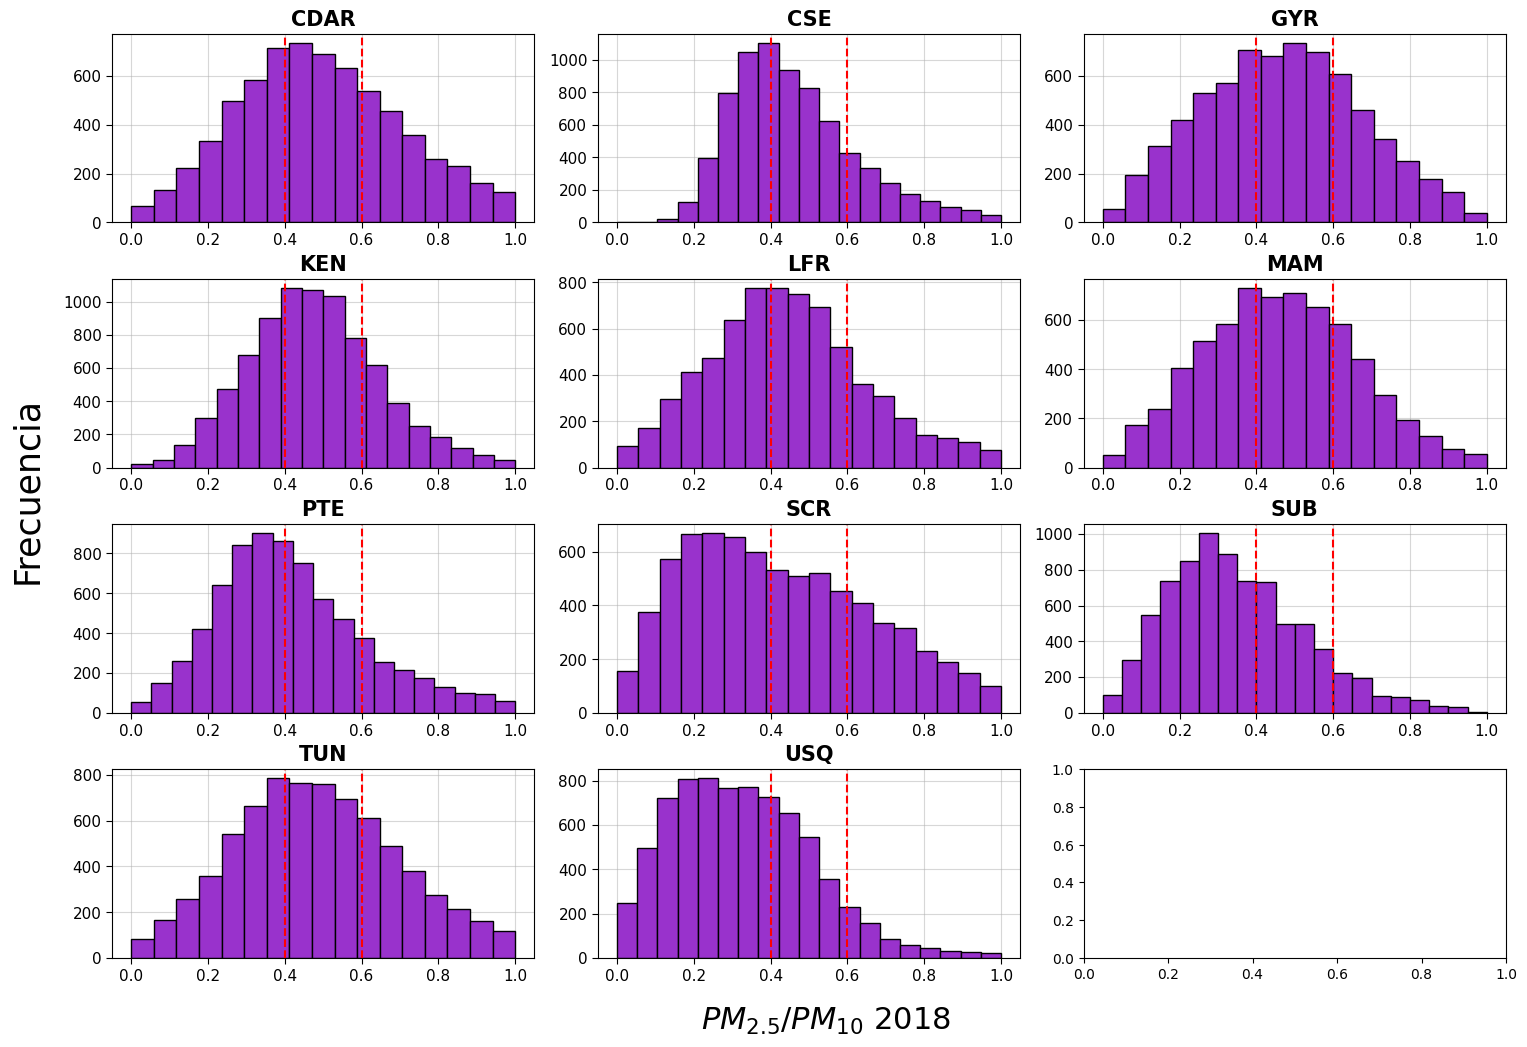

In [10]:
# graficamos los histogramas de los datos de 2018
graficar_histogramas(datos_2018, estaciones_2018, 2018)


In [11]:

# clasificamos los datos de 2020
clasificacion_2018 = clasificacion_set(datos_2018, estaciones_2018)


Clasificaciones:
CDAR: Mixed-Anthropogenic type (IIb1)
CSE: Typical Dust type (Ia)
GYR: Mixed-Anthropogenic type (IIb1)
KEN: Mixed-Anthropogenic type (IIb1)
LFR: Atypical Dust type (Ib)
MAM: Atypical Dust type (Ib)
PTE: Typical Dust type (Ia)
SCR: Atypical Dust type (Ib)
SUB: Typical Dust type (Ia)
TUN: Atypical Dust type (Ib)
USQ: Typical Dust type (Ia)


In [12]:

# graficamos el mapa con los datos
mapear_plotly(estaciones_2018, clasificacion_2018, 2018)

### Análisis de la distribución de $PM_{2.5}/PM_{10}$ en cada estación en 2019

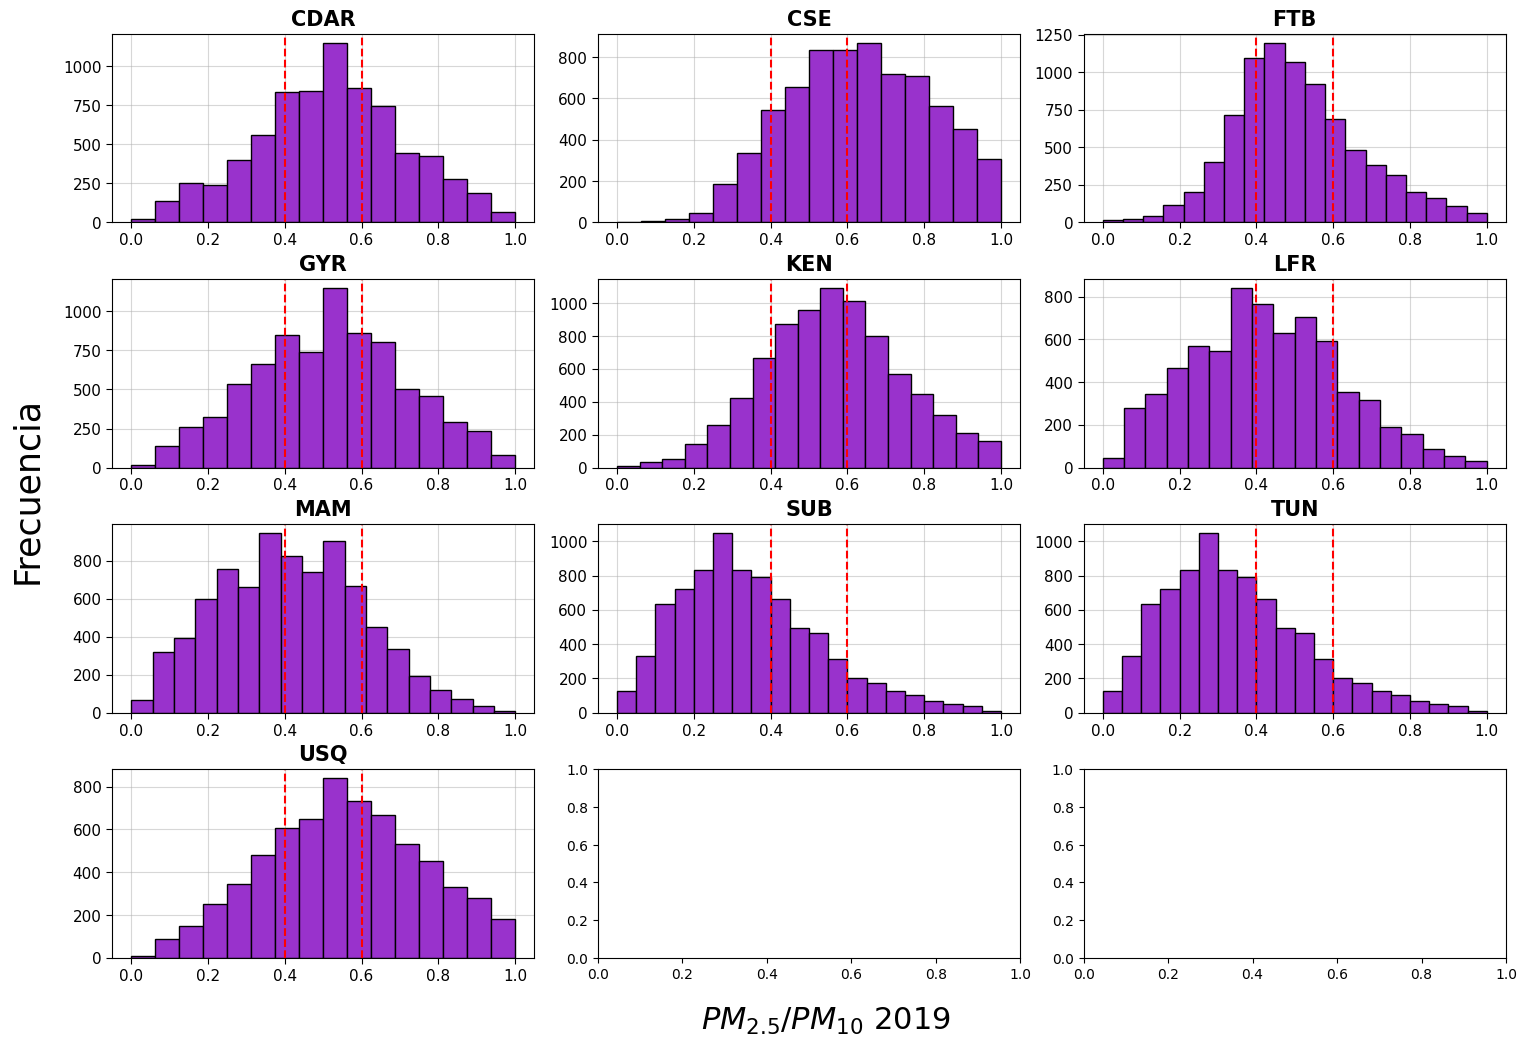

In [12]:
# graficamos los histogramas de los datos de 2019
graficar_histogramas(datos_2019, estaciones_2019, 2019)


In [13]:
# clasificamos los datos de 2020
clasificacion_2019 = clasificacion_set(datos_2019, estaciones_2019)


Clasificaciones:
CDAR: Mixed-Dust type (IIb2)
CSE: Atypical Anthropogenic type (IIIb)
FTB: Typical Mixed type (IIa)
GYR: Mixed-Anthropogenic type (IIb1)
KEN: Mixed-Anthropogenic type (IIb1)
LFR: Atypical Dust type (Ib)
MAM: Atypical Dust type (Ib)
SUB: Typical Dust type (Ia)
TUN: Typical Dust type (Ia)
USQ: Mixed-Dust type (IIb2)


In [14]:
# graficamos el mapa con los datos
mapear_plotly(estaciones_2019, clasificacion_2019, 2019)

### Análisis de la distribución de $PM_{2.5}/PM_{10}$ en cada estación en 2020

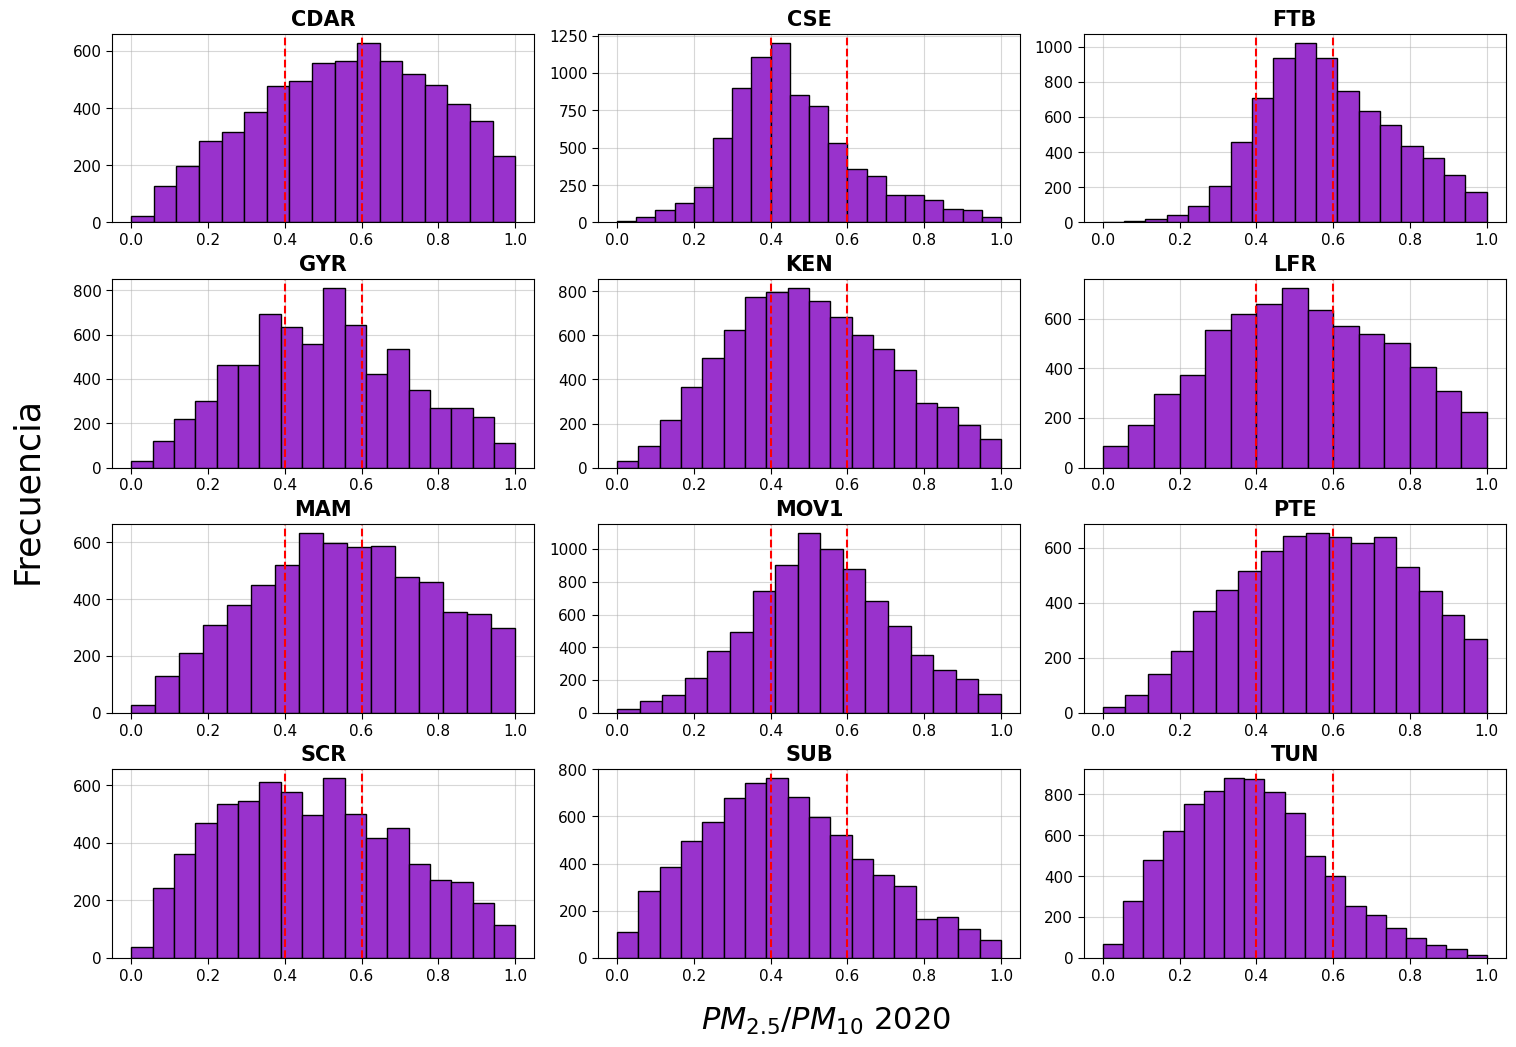

In [38]:
# graficamos los histogramas de los datos de 2020
graficar_histogramas(datos_2020, estaciones_2020, 2020)

In [15]:
# clasificamos los datos de 2020
clasificacion_2020 = clasificacion_set(datos_2020, estaciones_2020)

Clasificaciones:
CDAR: Atypical Anthropogenic type (IIIb)
CSE: Typical Mixed type (IIa)
FTB: Mixed-Anthropogenic type (IIb1)
GYR: Mixed-Anthropogenic type (IIb1)
KEN: Mixed-Anthropogenic type (IIb1)
LFR: Mixed-Anthropogenic type (IIb1)
MAM: Mixed-Dust type (IIb2)
MOV1: Mixed-Anthropogenic type (IIb1)
PTE: Mixed-Dust type (IIb2)
SCR: Mixed-Anthropogenic type (IIb1)
SUB: Mixed-Anthropogenic type (IIb1)
TUN: Atypical Dust type (Ib)


In [16]:
# graficamos el mapa con los datos
mapear_plotly(estaciones_2020, clasificacion_2020, 2020)

### Análisis de la distribución de $PM_{2.5}/PM_{10}$ en cada estación en 2021

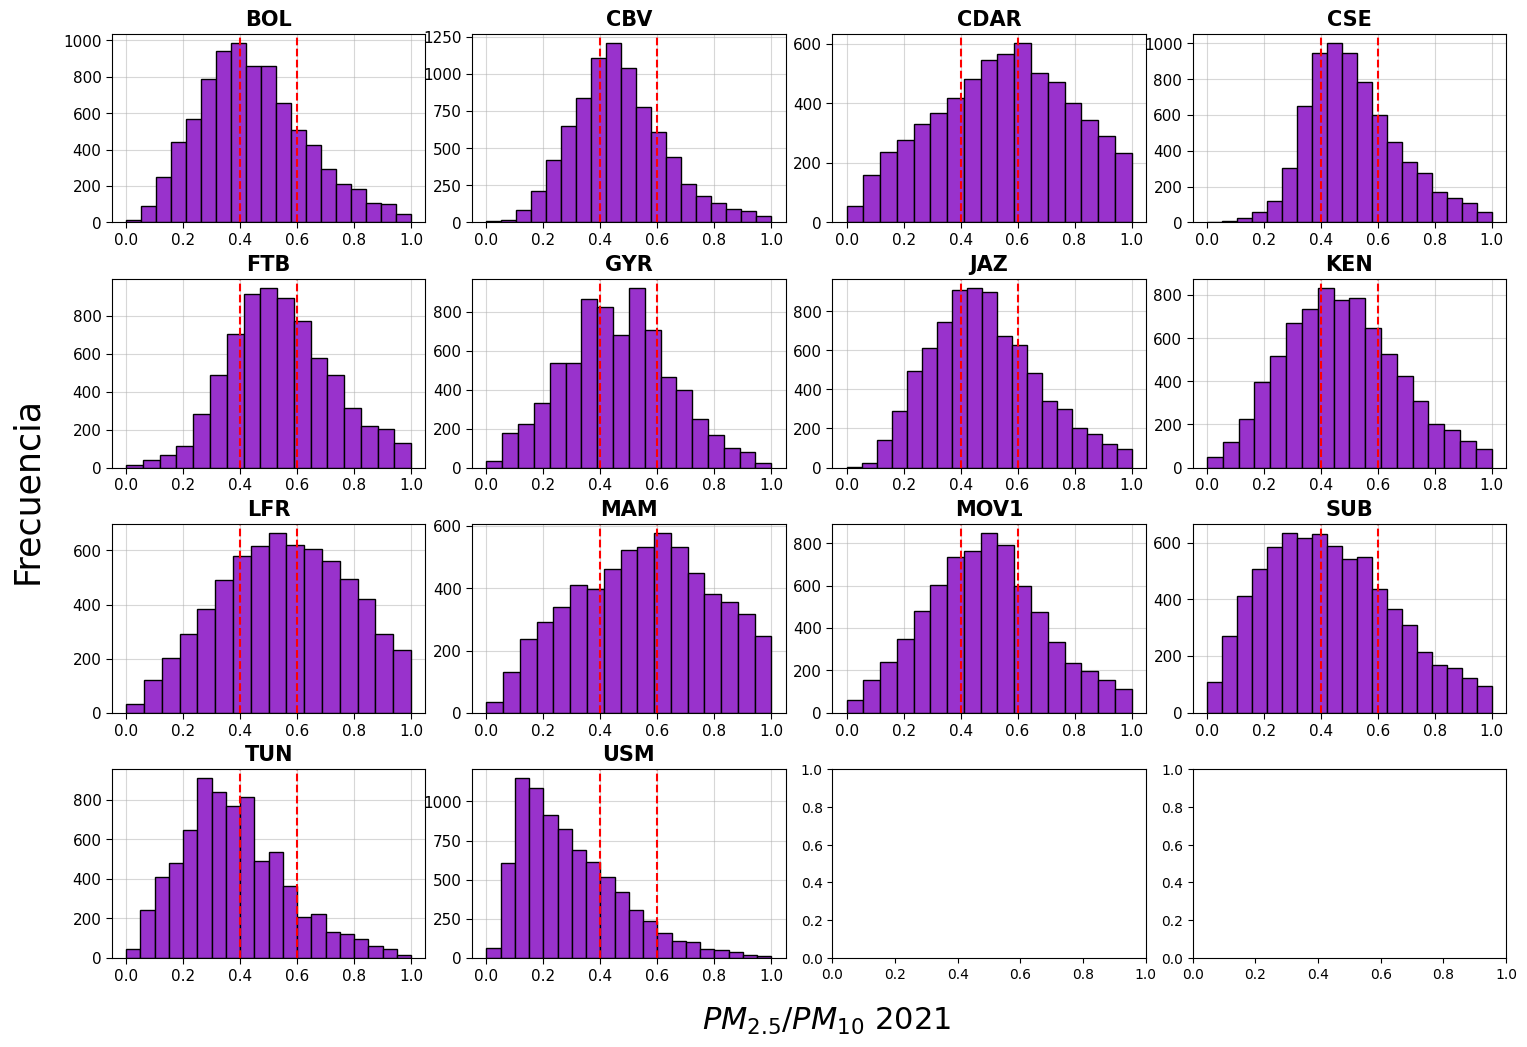

In [17]:
# graficamos los histogramas de los datos de 2021
graficar_histogramas(datos_2021, estaciones_2021, 2021)

In [18]:
# clasificamos los datos de 2021
clasificacion_2021 = clasificacion_set(datos_2021, estaciones_2021)

Clasificaciones:
BOL: Atypical Dust type (Ib)
CBV: Typical Mixed type (IIa)
CDAR: Atypical Anthropogenic type (IIIb)
CSE: Typical Mixed type (IIa)
FTB: Mixed-Anthropogenic type (IIb1)
GYR: Mixed-Anthropogenic type (IIb1)
JAZ: Mixed-Anthropogenic type (IIb1)
KEN: Mixed-Anthropogenic type (IIb1)
LFR: Mixed-Dust type (IIb2)
MAM: Atypical Anthropogenic type (IIIb)
MOV1: Mixed-Anthropogenic type (IIb1)
SUB: Atypical Dust type (Ib)
TUN: Typical Dust type (Ia)
USM: Typical Dust type (Ia)


In [19]:
# graficamos el mapa con los datos
mapear_plotly(estaciones_2021, clasificacion_2021, 2021)

### Análisis de la distribución de $PM_{2.5}/PM_{10}$ en cada estación en 2022

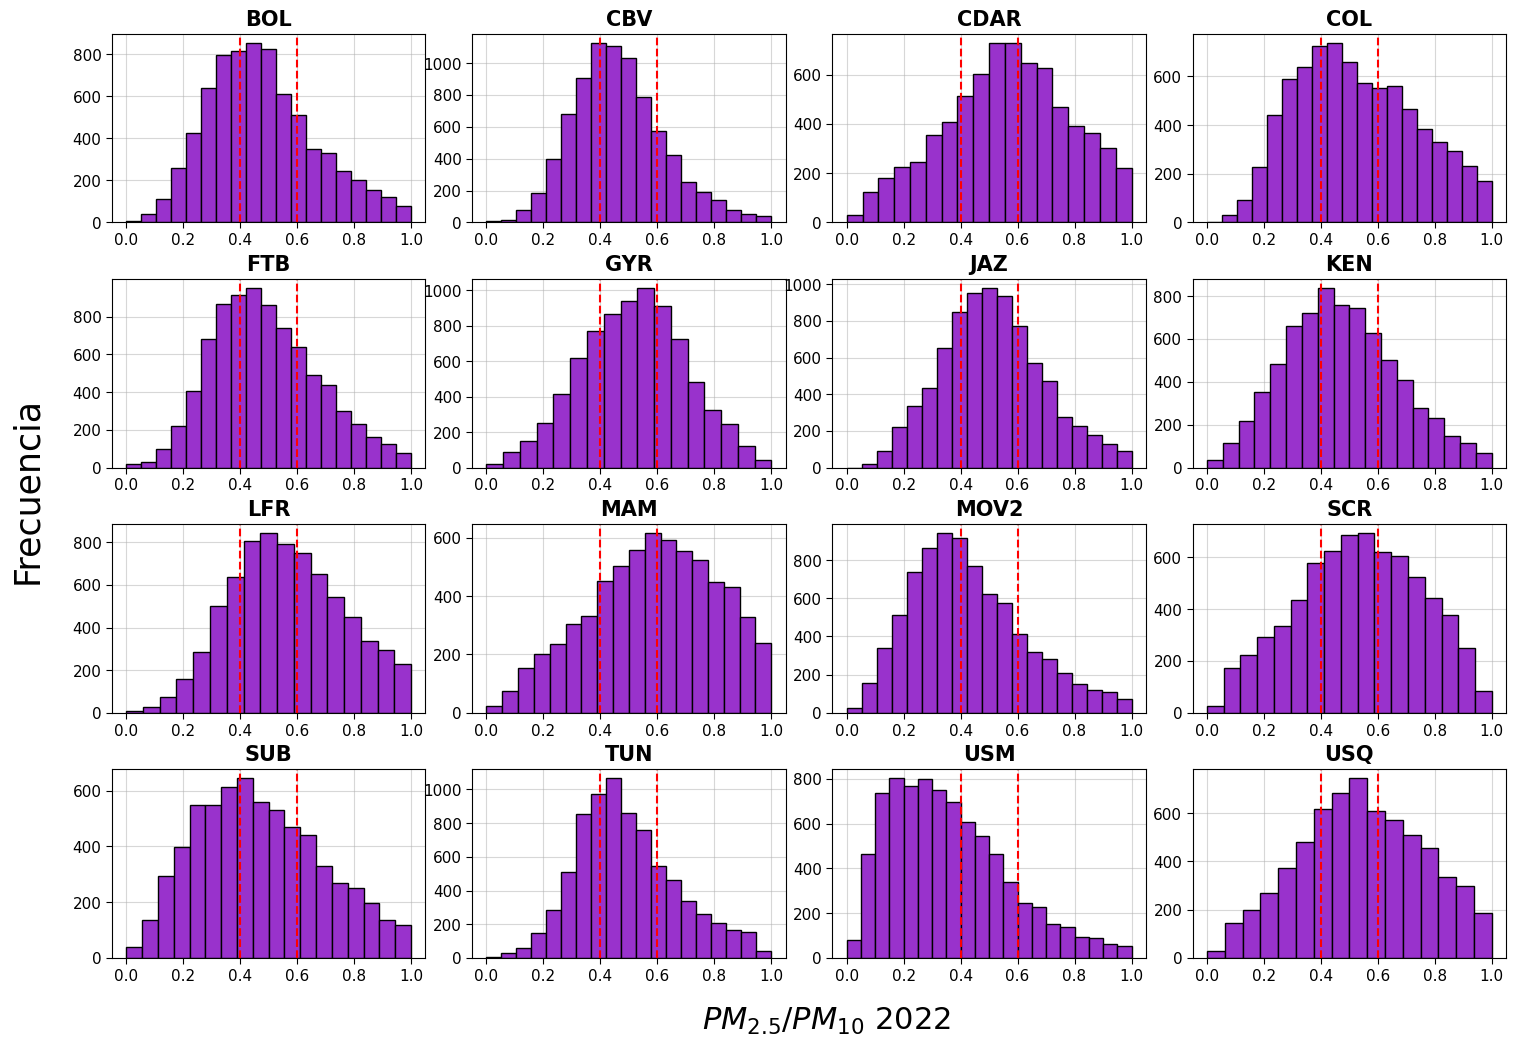

In [20]:
# graficamos los histogramas de los datos de 2022
graficar_histogramas(datos_2022, estaciones_2022, 2022)

In [21]:
# clasificamos los datos de 2022
clasificacion_2022 = clasificacion_set(datos_2022, estaciones_2022)

Clasificaciones:
BOL: Mixed-Anthropogenic type (IIb1)
CBV: Typical Dust type (Ia)
CDAR: Mixed-Dust type (IIb2)
COL: Mixed-Anthropogenic type (IIb1)
FTB: Mixed-Anthropogenic type (IIb1)
GYR: Mixed-Dust type (IIb2)
JAZ: Mixed-Anthropogenic type (IIb1)
KEN: Mixed-Anthropogenic type (IIb1)
LFR: Mixed-Anthropogenic type (IIb1)
MAM: Mixed-Dust type (IIb2)
MOV2: Atypical Dust type (Ib)
SCR: Mixed-Dust type (IIb2)
SUB: Mixed-Anthropogenic type (IIb1)
TUN: Mixed-Anthropogenic type (IIb1)
USM: Typical Dust type (Ia)
USQ: Mixed-Dust type (IIb2)


In [22]:
# graficamos el mapa con los datos
mapear_plotly(estaciones_2022, clasificacion_2022, 2022)

### Analisis de la distribución de $PM_{2.5}/PM_{10}$ en cada estación en todo el periodo de estudio

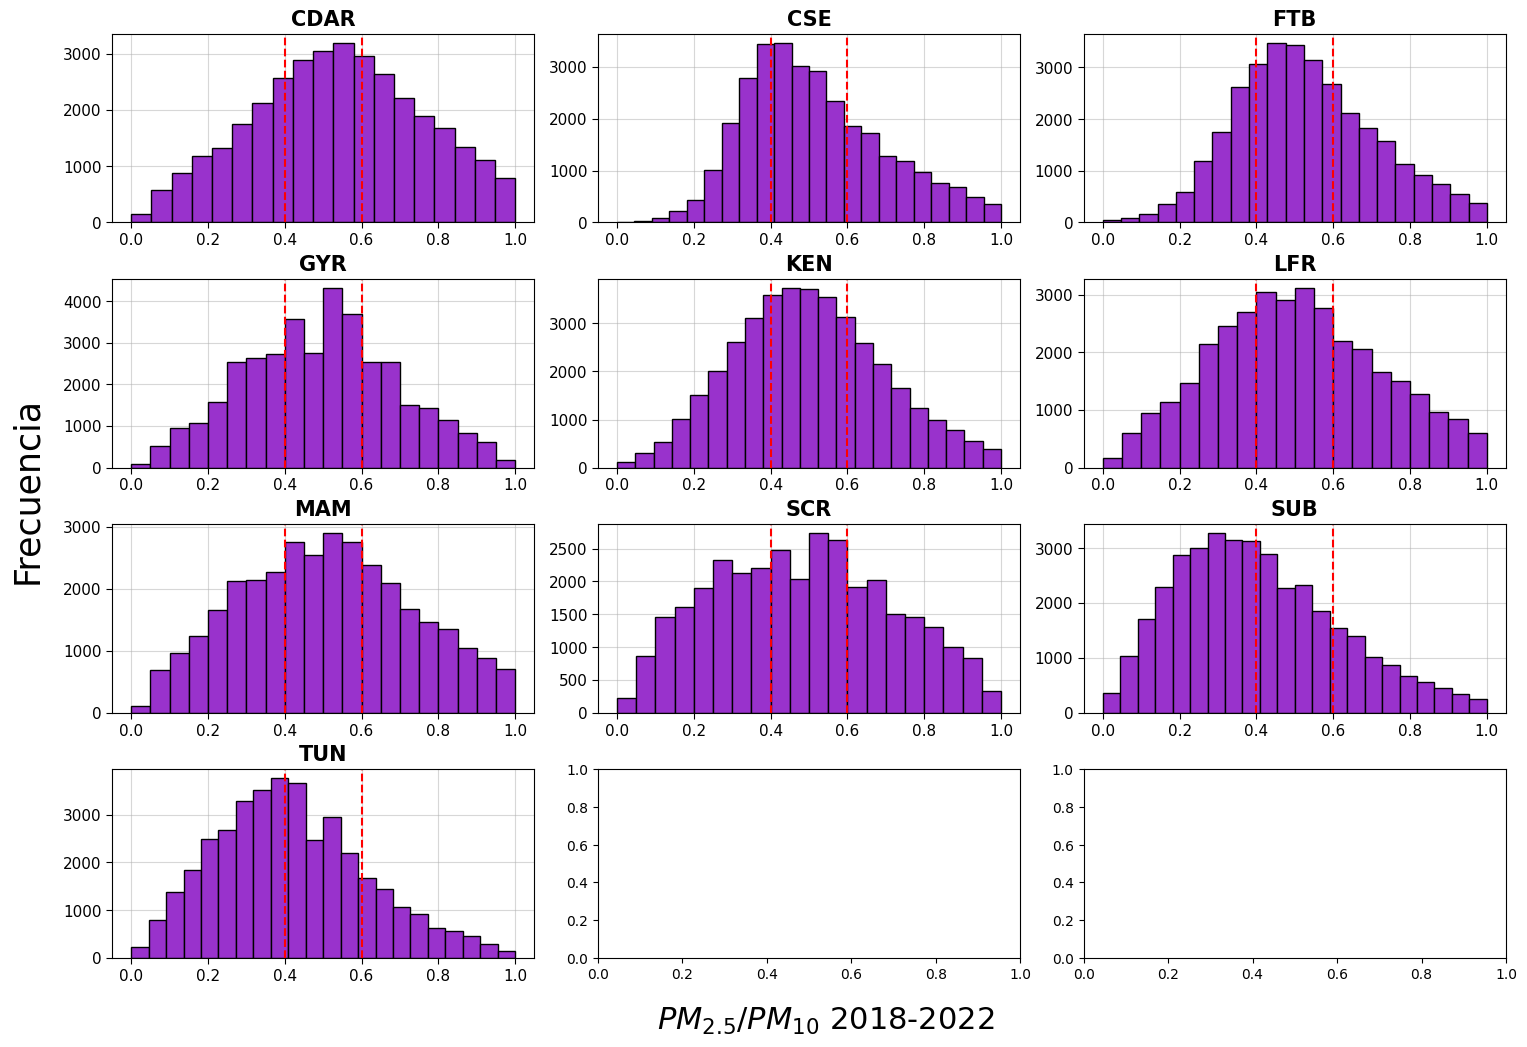

In [47]:
# graficamos los histogramas de los datos del periodo
graficar_histogramas(datos_periodo, estaciones_periodo, "2018-2022")

In [23]:
# clasificamos los datos del periodo
clasificacion_periodo = clasificacion_set(datos_periodo, estaciones_periodo)

Clasificaciones:
CDAR: Mixed-Dust type (IIb2)
CSE: Mixed-Anthropogenic type (IIb1)
FTB: Mixed-Anthropogenic type (IIb1)
GYR: Mixed-Anthropogenic type (IIb1)
KEN: Mixed-Anthropogenic type (IIb1)
LFR: Mixed-Anthropogenic type (IIb1)
MAM: Mixed-Anthropogenic type (IIb1)
SCR: Mixed-Anthropogenic type (IIb1)
SUB: Atypical Dust type (Ib)
TUN: Atypical Dust type (Ib)


In [24]:
# graficamos el mapa con los datos
mapear_plotly(estaciones_periodo, clasificacion_periodo, "2018-2022")

### Graficacion de los mapas en un mismo plot

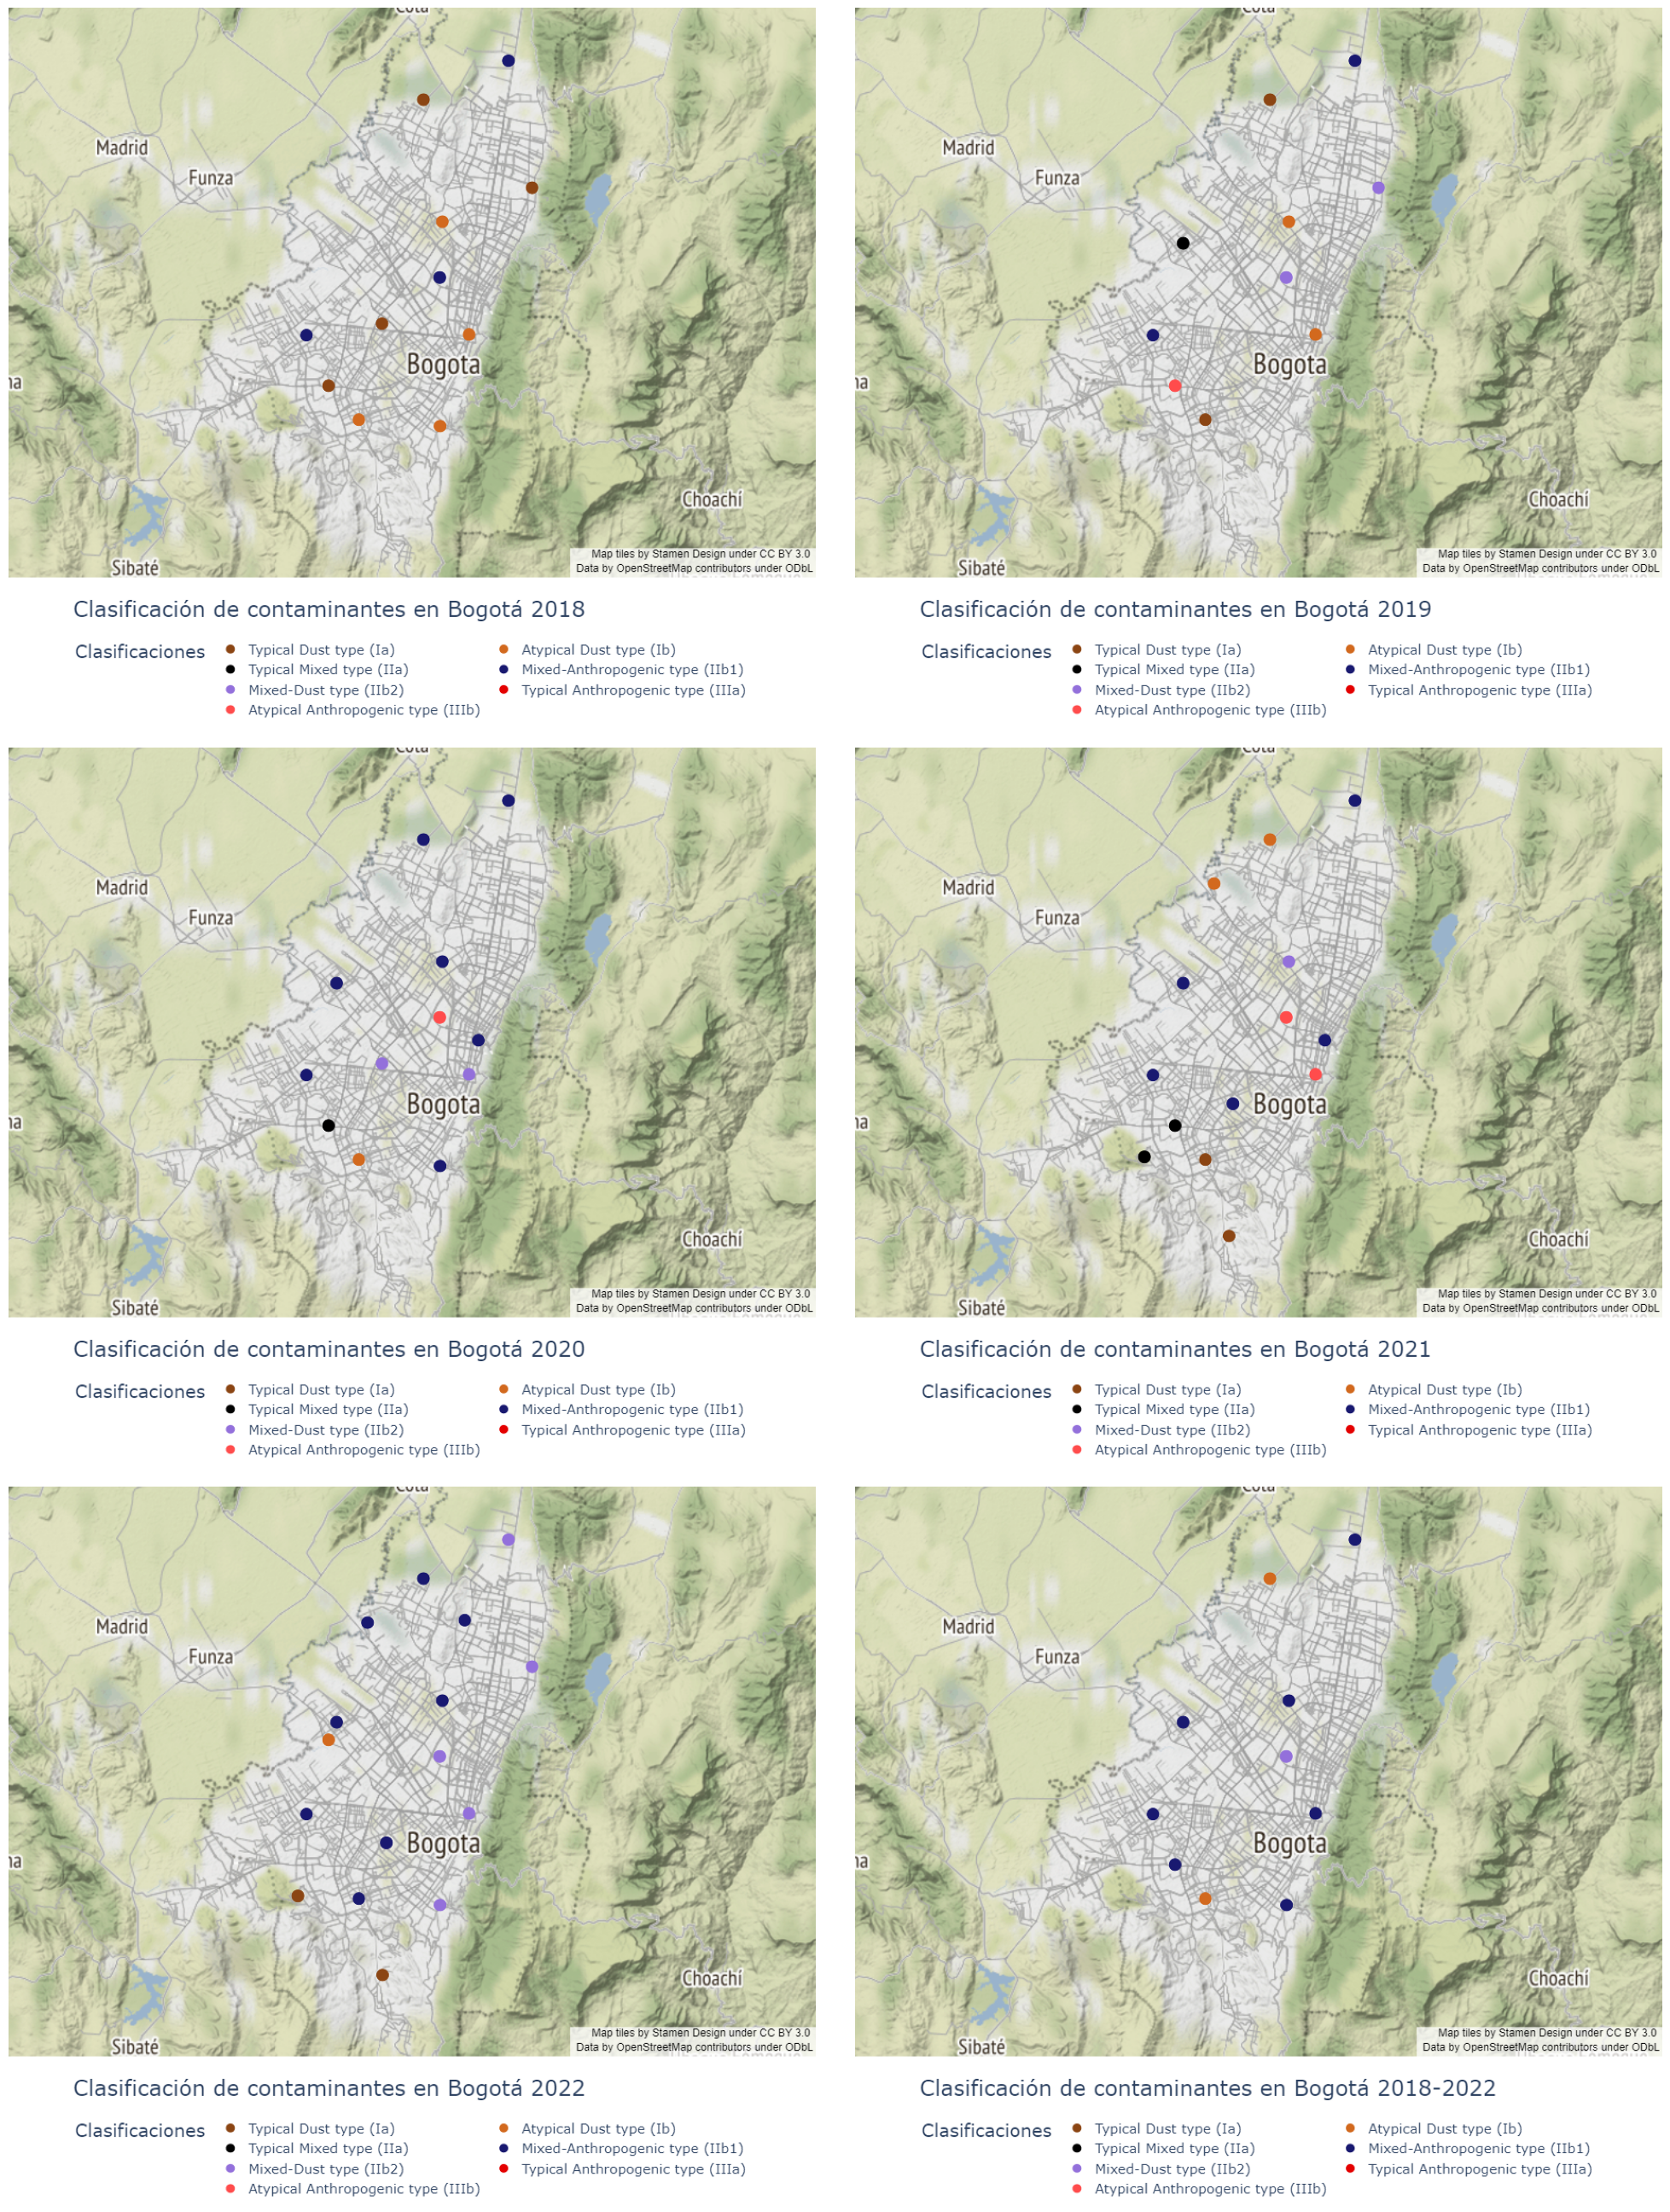

In [38]:
# creamos la figura
fig, ax = plt.subplots(3, 2, figsize=(25, 35))

# importamos los mapas
mapa_2018 = plt.imread("../data/results/map_2018.png")
mapa_2019 = plt.imread("../data/results/map_2019.png")
mapa_2020 = plt.imread("../data/results/map_2020.png")
mapa_2021 = plt.imread("../data/results/map_2021.png")
mapa_2022 = plt.imread("../data/results/map_2022.png")
mapa_periodo = plt.imread("../data/results/map_2018-2022.png")

# graficamos los mapas
ax[0, 0].imshow(mapa_2018) #new
ax[0, 1].imshow(mapa_2019) #new
ax[1, 0].imshow(mapa_2020)
ax[1, 1].imshow(mapa_2021)
ax[2, 0].imshow(mapa_2022)
ax[2, 1].imshow(mapa_periodo)


# quitamos los ejes
ax[0, 0].axis("off")
ax[0, 1].axis("off")
ax[1, 0].axis("off")
ax[1, 1].axis("off")
ax[2, 0].axis("off")
ax[2, 1].axis("off")

# quitamos los espacios entre los mapas
plt.subplots_adjust(wspace=0.05, hspace=-0.1)

# guardamos la imagen
plt.savefig("../data/results/mapas.png", bbox_inches="tight")

# mostramos la imagen
plt.show()


## 3. Correlación entre PM2.5, PM10 y PM2.5/PM10

### Definición función promedio

Obtenemos los datos por año del promedio diario de todas las estaciones

In [13]:
# definimos la función que obtiene el promedio de los datos de todas las estaciones dada una frecuencia
def promedio_estaciones(datos, estaciones, freq, carpeta="PM"):
    
    if carpeta == "PM":
        # creamos un dataframe para cada variable
        pm25 = pd.DataFrame()
        pm10 = pd.DataFrame()
        ratio = pd.DataFrame()

        # obtenemos los datos de cada estacion y los promediamos por frecuencia
        for i in estaciones:
            pm25[i] = datos[i]["PM2.5"].resample(freq).mean()
            pm10[i] = datos[i]["PM10"].resample(freq).mean()
            ratio[i] = datos[i]["ratio"].resample(freq).mean()

        # promediamos los datos de todas las estaciones
        pm25_mean = pm25.mean(axis=1)
        pm10_mean = pm10.mean(axis=1)
        ratio_mean = ratio.mean(axis=1)

        # calculamos la desviación estándar de los datos de todas las estaciones
        pm25_std = pm25.std(axis=1)
        pm10_std = pm10.std(axis=1)
        ratio_std = ratio.std(axis=1)

        # creamos un dataframe con los datos promediados
        datos_promedio = pd.DataFrame({"PM2.5": pm25_mean, "PM10": pm10_mean, "ratio": ratio_mean, "PM2.5_std": pm25_std, "PM10_std": pm10_std, "ratio_std": ratio_std})
    
    if carpeta == "precipitacion":
        precipitacion = pd.DataFrame()
        for i in estaciones:
            precipitacion[i] = datos[i]["Precipitacion"].resample(freq).sum()
        precipitacion_mean = precipitacion.mean(axis=1)
        precipitacion_std = precipitacion.std(axis=1)
        datos_promedio = pd.DataFrame({"Precipitacion": precipitacion_mean, "Precipitacion_std": precipitacion_std})

    return datos_promedio

# obtenemos los datos promediados por hora de cada año
datos_2018_promedio = promedio_estaciones(datos_2018, estaciones_2018, "D") #new
datos_2019_promedio = promedio_estaciones(datos_2019, estaciones_2019, "D") #new
datos_2020_promedio = promedio_estaciones(datos_2020, estaciones_2020, "D")
datos_2021_promedio = promedio_estaciones(datos_2021, estaciones_2021, "D")
datos_2022_promedio = promedio_estaciones(datos_2022, estaciones_2022, "D")

### Regresiones lineales y correlaciones

Realizamos una regresión lineal entre PM2.5 y PM10, entre PM2.5 y PM2.5/PM10 y entre PM10 y PM2.5/PM10

In [14]:
# hacemos un array para cada año con las regresiones (polyfit) entre PM2.5 y PM10,
#PM2.5 y ratio, y PM10 y ratio respectivamente

regresiones_2018 = np.array([np.polyfit(datos_2018_promedio["PM2.5"], datos_2018_promedio["PM10"], 1),
                             np.polyfit(datos_2018_promedio["PM2.5"], datos_2018_promedio["ratio"], 1),
                             np.polyfit(datos_2018_promedio["PM10"], datos_2018_promedio["ratio"], 1)])

regresiones_2019 = np.array([np.polyfit(datos_2019_promedio["PM2.5"], datos_2019_promedio["PM10"], 1),
                             np.polyfit(datos_2019_promedio["PM2.5"], datos_2019_promedio["ratio"], 1),
                             np.polyfit(datos_2019_promedio["PM10"], datos_2019_promedio["ratio"], 1)])

regresiones_2020 = np.array([np.polyfit(datos_2020_promedio["PM2.5"], datos_2020_promedio["PM10"], 1),
                             np.polyfit(datos_2020_promedio["PM2.5"], datos_2020_promedio["ratio"], 1),
                             np.polyfit(datos_2020_promedio["PM10"], datos_2020_promedio["ratio"], 1)])

regresiones_2021 = np.array([np.polyfit(datos_2021_promedio["PM2.5"], datos_2021_promedio["PM10"], 1),
                             np.polyfit(datos_2021_promedio["PM2.5"], datos_2021_promedio["ratio"], 1),
                             np.polyfit(datos_2021_promedio["PM10"], datos_2021_promedio["ratio"], 1)])

regresiones_2022 = np.array([np.polyfit(datos_2022_promedio["PM2.5"], datos_2022_promedio["PM10"], 1),
                             np.polyfit(datos_2022_promedio["PM2.5"], datos_2022_promedio["ratio"], 1),
                             np.polyfit(datos_2022_promedio["PM10"], datos_2022_promedio["ratio"], 1)])

Graficamos los datos con sus respectivas regresiones lineales y sus coeficientes de correlación

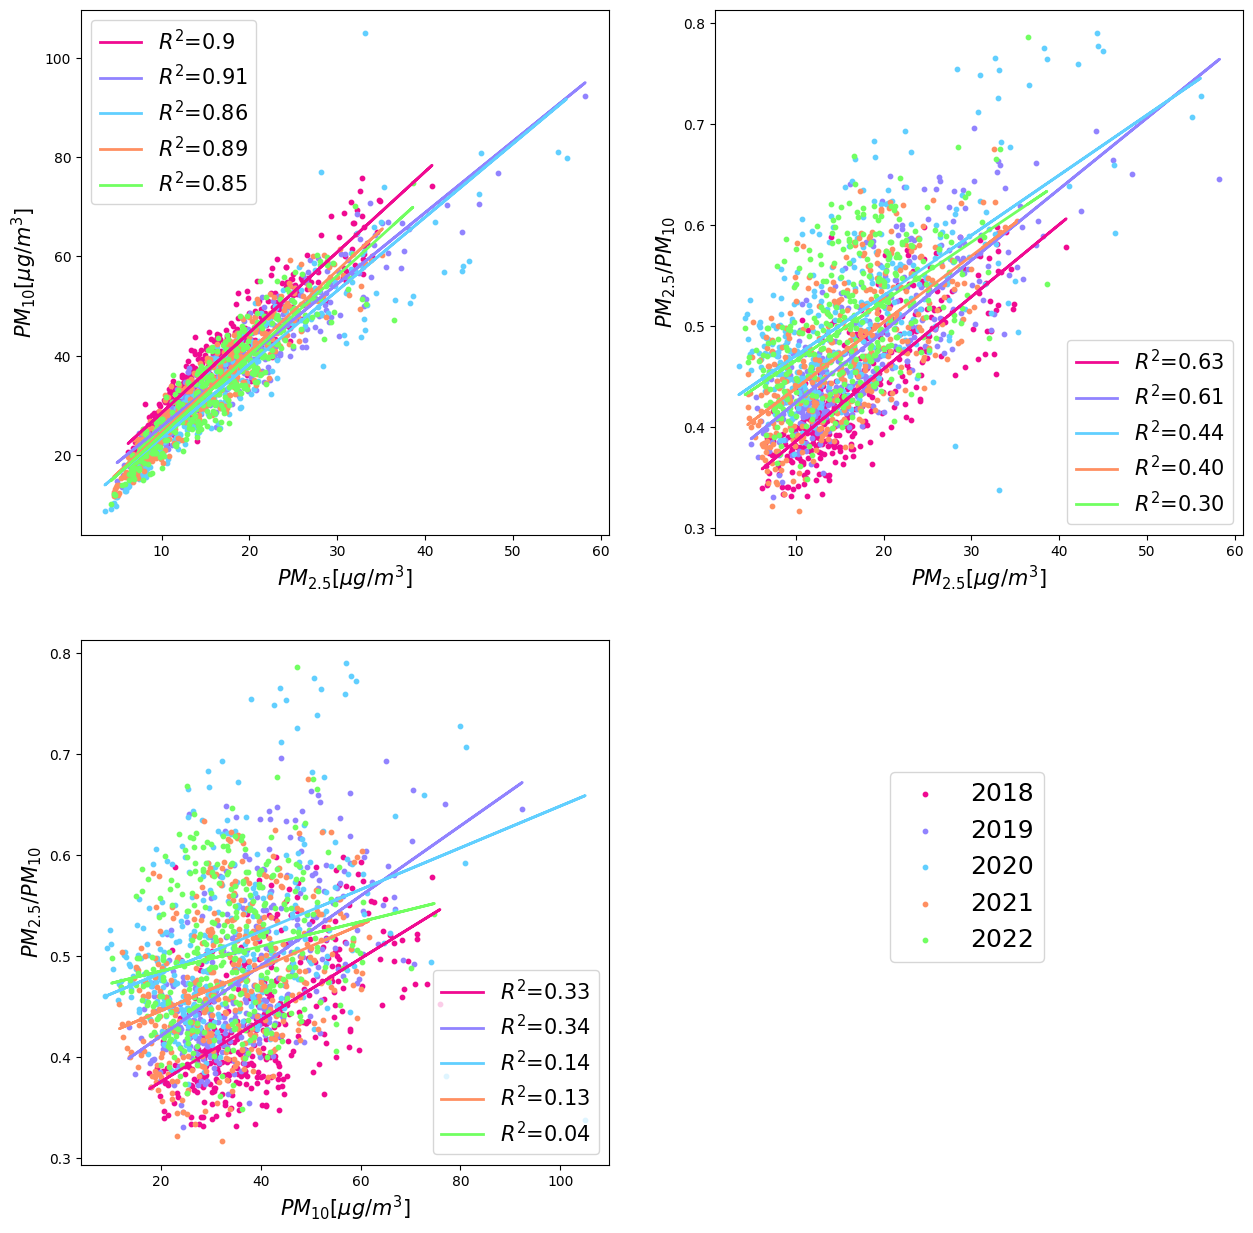

In [21]:
# creamos la figura
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

# graficamos las relaciones entre PM2.5 y PM10

linezero = ax[0, 0].scatter(datos_2018_promedio["PM2.5"],
                 datos_2018_promedio["PM10"],
                 s=10,
                 color="#f00a91",
                 )
ax[0, 0].plot(datos_2018_promedio["PM2.5"],
              regresiones_2018[0, 0]*datos_2018_promedio["PM2.5"]+regresiones_2018[0, 1],
              color="#f00a91",
              linewidth=2,
              label= "$R^2$="+str(round(np.corrcoef(datos_2018_promedio["PM2.5"], datos_2018_promedio["PM10"])[0,1]**2, 2))
              )

linehalf = ax[0, 0].scatter(datos_2019_promedio["PM2.5"],
                 datos_2019_promedio["PM10"],
                 s=10,
                 color="#9183ff",
                 )
ax[0, 0].plot(datos_2019_promedio["PM2.5"],
              regresiones_2019[0, 0]*datos_2019_promedio["PM2.5"]+regresiones_2019[0, 1],
              color="#9183ff",
              linewidth=2,
              label= "$R^2$="+str(round(np.corrcoef(datos_2019_promedio["PM2.5"], datos_2019_promedio["PM10"])[0,1]**2, 2))
              )

lineone = ax[0, 0].scatter(datos_2020_promedio["PM2.5"],
                 datos_2020_promedio["PM10"],
                 s=10,
                 color="#61cfff",
                 )
ax[0, 0].plot(datos_2020_promedio["PM2.5"],
              regresiones_2020[0, 0]*datos_2020_promedio["PM2.5"]+regresiones_2020[0, 1],
              color="#61cfff",
              linewidth=2,
              label= "$R^2$="+str(round(np.corrcoef(datos_2020_promedio["PM2.5"], datos_2020_promedio["PM10"])[0,1]**2, 2))
              )

linetwo = ax[0, 0].scatter(datos_2021_promedio["PM2.5"],
                 datos_2021_promedio["PM10"],
                 s=10,
                 color="#ff8f61",
                 )
ax[0, 0].plot(datos_2021_promedio["PM2.5"],
              regresiones_2021[0, 0]*datos_2021_promedio["PM2.5"]+regresiones_2021[0, 1],
              color="#ff8f61",
              linewidth=2,
              label= "$R^2$="+str(round(np.corrcoef(datos_2021_promedio["PM2.5"], datos_2021_promedio["PM10"])[0,1]**2, 2))
              )

linethree = ax[0, 0].scatter(datos_2022_promedio["PM2.5"],
                 datos_2022_promedio["PM10"],
                 s=10,
                 color="#71ff61",
                 )
ax[0, 0].plot(datos_2022_promedio["PM2.5"],
              regresiones_2022[0, 0]*datos_2022_promedio["PM2.5"]+regresiones_2022[0, 1],
              color="#71ff61",
              linewidth=2,
              label= "$R^2$="+str(round(np.corrcoef(datos_2022_promedio["PM2.5"], datos_2022_promedio["PM10"])[0,1]**2, 2))
              )



# graficamos las relaciones entre PM2.5 y ratio

#new
ax[0, 1].scatter(datos_2018_promedio["PM2.5"],
                 datos_2018_promedio["ratio"],
                 s=10,
                 color="#f00a91",
                 )
ax[0, 1].plot(datos_2018_promedio["PM2.5"],
              regresiones_2018[1, 0]*datos_2018_promedio["PM2.5"]+regresiones_2018[1, 1],
              color="#f00a91",
              linewidth=2,
              label= "$R^2$="+str(round(np.corrcoef(datos_2018_promedio["PM2.5"], datos_2018_promedio["ratio"])[0,1]**2, 2))
              )

ax[0, 1].scatter(datos_2019_promedio["PM2.5"],
                 datos_2019_promedio["ratio"],
                 s=10,
                 color="#9183ff",
                 )
ax[0, 1].plot(datos_2019_promedio["PM2.5"],
              regresiones_2019[1, 0]*datos_2019_promedio["PM2.5"]+regresiones_2019[1, 1],
              color="#9183ff",
              linewidth=2,
              label= "$R^2$="+str(round(np.corrcoef(datos_2019_promedio["PM2.5"], datos_2019_promedio["ratio"])[0,1]**2, 2))
              )
#new

ax[0, 1].scatter(datos_2020_promedio["PM2.5"],
                 datos_2020_promedio["ratio"],
                 s=10,
                 color="#61cfff",
                 )
ax[0, 1].plot(datos_2020_promedio["PM2.5"],
              regresiones_2020[1, 0]*datos_2020_promedio["PM2.5"]+regresiones_2020[1, 1],
              color="#61cfff",
              linewidth=2,
              label= "$R^2$="+str(round(np.corrcoef(datos_2020_promedio["PM2.5"], datos_2020_promedio["ratio"])[0,1]**2, 2))
              )

ax[0, 1].scatter(datos_2021_promedio["PM2.5"],
                 datos_2021_promedio["ratio"],
                 s=10,
                 color="#ff8f61",
                 )
ax[0, 1].plot(datos_2021_promedio["PM2.5"],
              regresiones_2021[1, 0]*datos_2021_promedio["PM2.5"]+regresiones_2021[1, 1],
              color="#ff8f61",
              linewidth=2,
            #   label= "$R^2$="+str(round(np.corrcoef(datos_2021_promedio["PM2.5"], datos_2021_promedio["ratio"])[0,1]**2, 2))
              label = "$R^2$={:.2f}".format(round(np.corrcoef(datos_2021_promedio["PM2.5"], datos_2021_promedio["ratio"])[0,1]**2, 2))
              )

ax[0, 1].scatter(datos_2022_promedio["PM2.5"],
                 datos_2022_promedio["ratio"],
                 s=10,
                 color="#71ff61",
                 )
ax[0, 1].plot(datos_2022_promedio["PM2.5"],
              regresiones_2022[1, 0]*datos_2022_promedio["PM2.5"]+regresiones_2022[1, 1],
              color="#71ff61",
              linewidth=2,
            #   label= "$R^2$="+str(round(np.corrcoef(datos_2022_promedio["PM2.5"], datos_2022_promedio["ratio"])[0,1]**2, 2))
              label = "$R^2$={:.2f}".format(round(np.corrcoef(datos_2022_promedio["PM2.5"], datos_2022_promedio["ratio"])[0,1]**2, 2))
              )

# graficamos las relaciones entre PM10 y ratio

#new
ax[1, 0].scatter(datos_2018_promedio["PM10"],
                 datos_2018_promedio["ratio"],
                 s=10,
                 color="#f00a91",
                 )
ax[1, 0].plot(datos_2018_promedio["PM10"],
              regresiones_2018[2, 0]*datos_2018_promedio["PM10"]+regresiones_2018[2, 1],
              color="#f00a91",
              linewidth=2,
              label= "$R^2$="+str(round(np.corrcoef(datos_2018_promedio["PM10"], datos_2018_promedio["ratio"])[0,1]**2, 2))
              )

ax[1, 0].scatter(datos_2019_promedio["PM10"],
                 datos_2019_promedio["ratio"],
                 s=10,
                 color="#9183ff",
                 )
ax[1, 0].plot(datos_2019_promedio["PM10"],
              regresiones_2019[2, 0]*datos_2019_promedio["PM10"]+regresiones_2019[2, 1],
              color="#9183ff",
              linewidth=2,
              label= "$R^2$="+str(round(np.corrcoef(datos_2019_promedio["PM10"], datos_2019_promedio["ratio"])[0,1]**2, 2))
              )
#new

ax[1, 0].scatter(datos_2020_promedio["PM10"],
                 datos_2020_promedio["ratio"],
                 s=10,
                 color="#61cfff",
                 )
ax[1, 0].plot(datos_2020_promedio["PM10"],
              regresiones_2020[2, 0]*datos_2020_promedio["PM10"]+regresiones_2020[2, 1],
              color="#61cfff",
              linewidth=2,
              label= "$R^2$="+str(round(np.corrcoef(datos_2020_promedio["PM10"], datos_2020_promedio["ratio"])[0,1]**2, 2))
              )

ax[1, 0].scatter(datos_2021_promedio["PM10"],
                 datos_2021_promedio["ratio"],
                 s=10,
                 color="#ff8f61",
                 )
ax[1, 0].plot(datos_2021_promedio["PM10"],
              regresiones_2021[2, 0]*datos_2021_promedio["PM10"]+regresiones_2021[2, 1],
              color="#ff8f61",
              linewidth=2,
              label= "$R^2$="+str(round(np.corrcoef(datos_2021_promedio["PM10"], datos_2021_promedio["ratio"])[0,1]**2, 2))
              )

ax[1, 0].scatter(datos_2022_promedio["PM10"],
                 datos_2022_promedio["ratio"],
                 s=10,
                 color="#71ff61",
                 )
ax[1, 0].plot(datos_2022_promedio["PM10"],
              regresiones_2022[2, 0]*datos_2022_promedio["PM10"]+regresiones_2022[2, 1],
              color="#71ff61",
              linewidth=2,
              label= "$R^2$="+str(round(np.corrcoef(datos_2022_promedio["PM10"], datos_2022_promedio["ratio"])[0,1]**2, 2))
              )

# añadimos los labels
ax[0, 0].set_xlabel(r"$PM_{2.5} [\mu g / m^3]$", fontsize=15)
ax[0, 0].set_ylabel(r"$PM_{10} [\mu g / m^3]$", fontsize=15)
ax[0, 1].set_xlabel(r"$PM_{2.5} [\mu g / m^3]$", fontsize=15)
ax[0, 1].set_ylabel(r"$PM_{2.5}/PM_{10}$", fontsize=15)
ax[1, 0].set_xlabel(r"$PM_{10} [\mu g / m^3]$", fontsize=15)
ax[1, 0].set_ylabel(r"$PM_{2.5}/PM_{10}$", fontsize=15)

# eliminamos los ejes del 4to cuadrante
ax[1,1].axis("off")

# añadimos las leyendas
ax[0,0].legend(fontsize=15)
ax[0,1].legend(fontsize=15)
ax[1,0].legend(fontsize=15)

fig.legend([linezero,linehalf, lineone, linetwo, linethree], ["2018","2019","2020", "2021", "2022"], loc=(0.71,0.22), fontsize=18)

# guardamos la imagen
plt.savefig("../data/results/corelaciones.png", dpi=300, bbox_inches="tight")


## 4. Variacion temporal del material particulado, cociente PM2.5/PM10 y precipitación

### Cálculo promedios material particulado por año

In [ ]:
# calculamos los promedios anuales de PM2.5 y PM10
pm25 = pd.DataFrame()
pm10 = pd.DataFrame()
means = []
stds = []
for i,j in [(datos_2018, estaciones_2018), (datos_2019, estaciones_2019),(datos_2020, estaciones_2020), (datos_2021, estaciones_2021), (datos_2022, estaciones_2022)]:
    for k in j:
        pm25 = pd.concat([pm25, i[k]["PM2.5"]])
        pm10 = pd.concat([pm10, i[k]["PM10"]])
    means.append([pm25.mean().values[0], pm10.mean().values[0]])
    stds.append([pm25.std().values[0], pm10.std().values[0]])

# imprimimos los promedios anuales de PM2.5 y PM10 con su desviación estándar

print("Promedio anual de 2020 de PM2.5 y PM10: {:.2f} ± {:.2f} y {:.2f} ± {:.2f}".format(means[0][0], stds[0][0], means[0][1], stds[0][1]))
print("Promedio anual de 2021 de PM2.5 y PM10: {:.2f} ± {:.2f} y {:.2f} ± {:.2f}".format(means[1][0], stds[1][0], means[1][1], stds[1][1]))
print("Promedio anual de 2022 de PM2.5 y PM10: {:.2f} ± {:.2f} y {:.2f} ± {:.2f}".format(means[2][0], stds[2][0], means[2][1], stds[2][1]))



Promedio anual de 2020 de PM2.5 y PM10: 17.61 ± 13.81 y 35.41 ± 25.10
Promedio anual de 2021 de PM2.5 y PM10: 16.80 ± 13.12 y 35.16 ± 24.05
Promedio anual de 2022 de PM2.5 y PM10: 16.71 ± 12.34 y 35.10 ± 23.21


### Importación de datos de precipitación

Improtamos los datos de precipitación

In [22]:
#Quitamos MOV2 de las estaciones pues no tiene datos de precipitación
estaciones_precipitacion = estaciones.copy()
estaciones_precipitacion.remove("MOV2")

#Usamos la función de importacion para la precipitación de cada año
precipitacion_2018, porcentaje_precipitacion_2018 = importar_datos_individuales(estaciones_precipitacion, 2018, ["Precipitacion"], "precipitacion")
precipitacion_2019, porcentaje_precipitacion_2019 = importar_datos_individuales(estaciones_precipitacion, 2019, ["Precipitacion"], "precipitacion")
precipitacion_2020, porcentaje_precipitacion_2020 = importar_datos_individuales(estaciones_precipitacion, 2020, ["Precipitacion"], "precipitacion")
precipitacion_2021, porcentaje_precipitacion_2021 = importar_datos_individuales(estaciones_precipitacion, 2021, ["Precipitacion"], "precipitacion")
precipitacion_2022, porcentaje_precipitacion_2022 = importar_datos_individuales(estaciones_precipitacion, 2022, ["Precipitacion"], "precipitacion")

In [ ]:
# imprimimos el porcentaje de datos validos de cada estacion
print("Porcentaje de datos validos (precipitacion) en 2018 -> 2019 -> 2020 -> 2021 -> 2022 -> [2018-2022]:")
tot_periodo_preci = {}
for i, estacion in enumerate(estaciones_precipitacion):
    tot_periodo_preci[estacion] = (porcentaje_precipitacion_2018[estacion]+porcentaje_precipitacion_2019[estacion]+porcentaje_precipitacion_2020[estacion]+porcentaje_precipitacion_2021[estacion]+porcentaje_precipitacion_2022[estacion])/5*100
    print(f"{i+1}. {estacion}: {porcentaje_precipitacion_2018[estacion]*100:.2f}% -> {porcentaje_precipitacion_2019[estacion]*100:.2f}% -> {porcentaje_precipitacion_2020[estacion]*100:.2f}% -> {porcentaje_precipitacion_2021[estacion]*100:.2f}% -> {porcentaje_precipitacion_2022[estacion]*100:.2f}% -> {tot_periodo_preci[estacion]:.2f}%")

Porcentaje de datos validos (precipitacion) en 2018 -> 2019 -> 2020 -> 2021 -> 2022 -> [2018-2022]:
1. BOL: 79.02% -> 69.42% -> 0.00% -> 45.79% -> 99.60% -> 58.76%
2. CBV: 0.00% -> 0.00% -> 0.00% -> 0.00% -> 43.16% -> 8.63%
3. CDAR: 97.65% -> 99.89% -> 99.86% -> 99.68% -> 99.29% -> 99.27%
4. COL: 0.00% -> 0.00% -> 0.00% -> 0.00% -> 39.95% -> 7.99%
5. CSE: 91.88% -> 98.92% -> 95.43% -> 99.54% -> 98.64% -> 96.88%
6. FTB: 4.12% -> 24.00% -> 0.00% -> 47.75% -> 99.55% -> 35.08%
7. GYR: 96.67% -> 99.61% -> 98.20% -> 98.13% -> 94.09% -> 97.34%
8. JAZ: 0.00% -> 0.00% -> 0.00% -> 0.00% -> 44.26% -> 8.85%
9. KEN: 99.77% -> 99.85% -> 91.69% -> 24.44% -> 16.44% -> 66.44%
10. LFR: 92.32% -> 98.46% -> 98.69% -> 99.68% -> 97.44% -> 97.32%
11. MAM: 81.27% -> 74.50% -> 99.95% -> 99.66% -> 99.13% -> 90.90%
12. MOV1: 54.73% -> 74.99% -> 99.62% -> 99.51% -> 90.71% -> 83.91%
13. PTE: 99.78% -> 99.94% -> 99.87% -> 62.71% -> 44.43% -> 81.35%
14. SCR: 99.84% -> 99.01% -> 99.47% -> 99.67% -> 91.69% -> 97.94%
1

In [ ]:
# en cada grupo de datos por año, eliminamos las estaciones con menos del 70% de datos validos
estaciones_precipitacion_periodo = [i for i in estaciones_precipitacion if tot_periodo_preci[i] >= 70]
precipitacion_periodo = {i: pd.concat([precipitacion_2018[i], precipitacion_2019[i],precipitacion_2020[i], precipitacion_2021[i], precipitacion_2022[i]]) for i in estaciones_precipitacion_periodo}

estaciones_precipitacion_2018 = [i for i in estaciones_precipitacion if porcentaje_precipitacion_2018[i] >= 0.7]
precipitacion_2018 = {i: precipitacion_2018[i] for i in estaciones_precipitacion_2018}
estaciones_precipitacion_2019 = [i for i in estaciones_precipitacion if porcentaje_precipitacion_2019[i] >= 0.7]
precipitacion_2019 = {i: precipitacion_2019[i] for i in estaciones_precipitacion_2019}
estaciones_precipitacion_2020 = [i for i in estaciones_precipitacion if porcentaje_precipitacion_2020[i] >= 0.7]
precipitacion_2020 = {i: precipitacion_2020[i] for i in estaciones_precipitacion_2020}
estaciones_precipitacion_2021 = [i for i in estaciones_precipitacion if porcentaje_precipitacion_2021[i] >= 0.7]
precipitacion_2021 = {i: precipitacion_2021[i] for i in estaciones_precipitacion_2021}
estaciones_precipitacion_2022 = [i for i in estaciones_precipitacion if porcentaje_precipitacion_2022[i] >= 0.7]
precipitacion_2022 = {i: precipitacion_2022[i] for i in estaciones_precipitacion_2022}

# imprimimos la cantidad de estaciones que quedaron en cada grupo
print(f"\nCantidad de estaciones con mas del 70% de datos validos (precipitacion) en 2020 -> 2021 -> 2022 -> [2020-2022]:")
print(f"{len(estaciones_precipitacion_2018)} -> {len(estaciones_precipitacion_2019)} ->{len(estaciones_precipitacion_2020)} -> {len(estaciones_precipitacion_2021)} -> {len(estaciones_precipitacion_2022)} -> {len(estaciones_precipitacion_periodo)}")

NameError: name 'estaciones_precipitacion' is not defined

### Variación anual de material particulado y PM2.5/PM10

Generamos un DataFrame con los datos mensuales promediados de cada estación de los tres años

In [ ]:
# hacemos un DataFrame para PM2.5 y PM10 de todas las estaciones de todos los años
pm25 = pd.DataFrame()
pm10 = pd.DataFrame()

# hacemos un loop para cada año ingresando todos los datos de cada estación
for i,j in [(datos_2018, estaciones_2018), (datos_2019,estaciones_2019), (datos_2020, estaciones_2020), (datos_2021, estaciones_2021), (datos_2022, estaciones_2022)]:
    for k in j:
        # concatenamos los datos de cada estación
        pm25 = pd.concat([pm25, i[k]["PM2.5"].resample("M").mean().reset_index(drop=True)[0:12]] , axis=1)
        pm10 = pd.concat([pm10, i[k]["PM10"].resample("M").mean().reset_index(drop=True)[0:12]] , axis=1)

# hacemos un DataFrame con los datos mensuales de PM2.5 y PM10 de todo el conjunto y sus desviaciones estándar
datos_mensual = pd.DataFrame({"PM2.5": pm25.mean(axis=1), "PM10": pm10.mean(axis=1), "PM2.5_std": pm25.std(axis=1), "PM10_std": pm10.std(axis=1)})

# ahora para la precipitacion
precipitacion = pd.DataFrame()
for i,j in [_(precipitacion_2020, estaciones_precipitacion_2020), (precipitacion_2021, estaciones_precipitacion_2021), (precipitacion_2022, estaciones_precipitacion_2022)]:
    for k in j:
        precipitacion = pd.concat([precipitacion, i[k]["Precipitacion"].resample("M").sum().reset_index(drop=True)[0:12]] , axis=1)
precipitacion_mensual = pd.DataFrame({"Precipitacion": precipitacion.mean(axis=1), "Precipitacion_std": precipitacion.std(axis=1)})

NameError: name 'precipitacion_2020' is not defined

Graficamos el comportamiento mensual de los datos con barras para PM2.5 y PM10 lado a lado, y puntos-linea para el ratio (con escala a la derecha)

In [ ]:
# creamos la figura
plt.figure(figsize=(15, 10))

# graficamos los datos PM2.5 y PM10 con su desviación estándar
plt.bar((datos_mensual.index+1)+0.2, datos_mensual["PM2.5"], color="#61cfff", edgecolor="black", label=r"$PM_{2.5}$", width=0.4)
plt.bar((datos_mensual.index+1)-0.2, datos_mensual["PM10"], color="#ff8f61", edgecolor="black", label=r"$PM_{10}$", width=0.4)
plt.errorbar((datos_mensual.index+1+0.2), datos_mensual["PM2.5"], yerr=datos_mensual["PM2.5_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)
plt.errorbar((datos_mensual.index+1-0.2), datos_mensual["PM10"], yerr=datos_mensual["PM10_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)

# añadimos los labels
plt.legend(fontsize=15, loc="upper left")
plt.xlabel("Mes", fontsize=18)
plt.ylabel(r"Concentración $[\mu g / m^3]$", fontsize=18)
plt.ylim(0, 80)
plt.xticks(np.arange(1, 13), ["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], fontsize=15)
plt.grid(alpha=0.5)
plt.gca().set_axisbelow(True)

# graficamos el ratio
plt.twinx() # creamos un segundo eje y
plt.plot(datos_mensual.index+1, datos_mensual["PM2.5"]/datos_mensual["PM10"], "o-", color="#71ff61", label=r"$PM_{2.5}/PM_{10}$")

###

# plt.twinx()
# plt.plot(precipitacion_mensual.index+1, precipitacion_mensual["Precipitacion"], "o-", color="#ff61ff", label="Precipitación")
# # plt.errorbar(precipitacion_mensual.index+1, precipitacion_mensual["Precipitacion"], yerr=precipitacion_mensual["Precipitacion_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)
# plt.ylabel(r"Precipitación $[mm]$", fontsize=18)
# plt.ylim(0, 0.2)

###

# añadimos los labels
plt.ylabel(r"$PM_{2.5}/PM_{10}$", fontsize=18)
plt.ylim(0.3, 0.6)
plt.legend(fontsize=15)

# guardamos la imagen
plt.savefig("../data/results/comportamiento_mensual.png", dpi=300, bbox_inches="tight")

# mostramos la imagen
plt.show()

Verificamos este comportamiento para cada año para ver su variación

C:\Users\nicom\AppData\Local\Temp\ipykernel_25648\3984826487.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


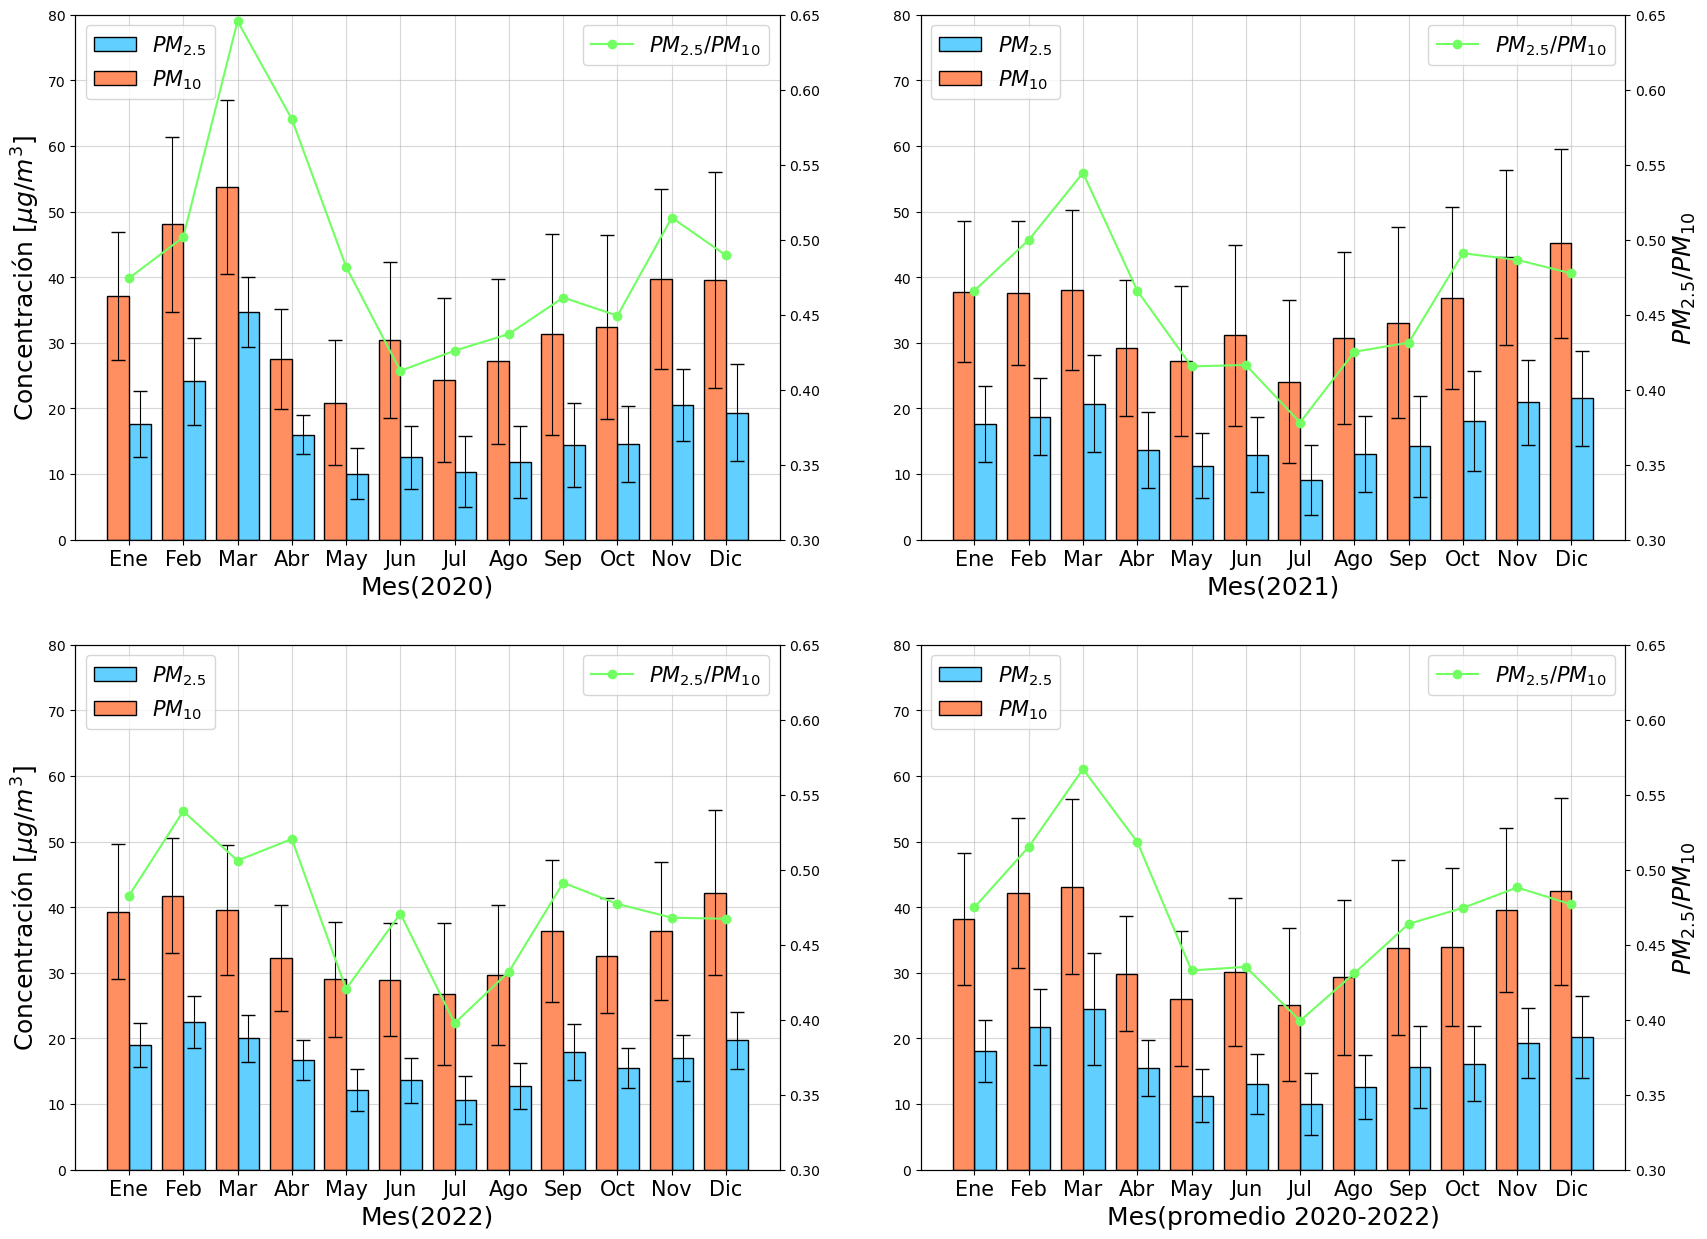

In [ ]:
# creamos los dataframes de cada año de forma mensual
datos_2020_mensual = promedio_estaciones(datos_2020, estaciones_2020, "M")["2020-01-01":"2020-12-31"].reset_index(drop=True)
datos_2021_mensual = promedio_estaciones(datos_2021, estaciones_2021, "M")["2021-01-01":"2021-12-31"].reset_index(drop=True)
datos_2022_mensual = promedio_estaciones(datos_2022, estaciones_2022, "M")["2022-01-01":"2022-12-31"].reset_index(drop=True)
precipitacion_2020_mensual = promedio_estaciones(precipitacion_2020, estaciones_precipitacion_2020, "M", "precipitacion")["2020-01-01":"2020-12-31"].reset_index(drop=True)
precipitacion_2021_mensual = promedio_estaciones(precipitacion_2021, estaciones_precipitacion_2021, "M", "precipitacion")["2021-01-01":"2021-12-31"].reset_index(drop=True)
precipitacion_2022_mensual = promedio_estaciones(precipitacion_2022, estaciones_precipitacion_2022, "M", "precipitacion")["2022-01-01":"2022-12-31"].reset_index(drop=True)

# realizamos la grafica de barras hecha en el punto anterior para cada año
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

#-----2020-----#
# graficamos los datos PM2.5 y PM10 con su desviación estándar
p1 = ax[0, 0].bar((datos_2020_mensual.index+1)+0.2, datos_2020_mensual["PM2.5"], color="#61cfff", edgecolor="black", label=r"$PM_{2.5}$", width=0.4)
p2 = ax[0, 0].bar((datos_2020_mensual.index+1)-0.2, datos_2020_mensual["PM10"], color="#ff8f61", edgecolor="black", label=r"$PM_{10}$", width=0.4)
ax[0, 0].errorbar((datos_2020_mensual.index+1+0.2), datos_2020_mensual["PM2.5"], yerr=datos_2020_mensual["PM2.5_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)
ax[0, 0].errorbar((datos_2020_mensual.index+1-0.2), datos_2020_mensual["PM10"], yerr=datos_2020_mensual["PM10_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)

# añadimos los labels
ax[0, 0].legend(fontsize=15, loc="upper left")
ax[0, 0].set_xlabel("Mes(2020)", fontsize=18)
ax[0, 0].set_ylabel(r"Concentración $[\mu g / m^3]$", fontsize=18)
ax[0, 0].set_ylim(0, 80)
ax[0, 0].set_xticks(np.arange(1, 13))
ax[0, 0].set_xticklabels(["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], fontsize=15)
ax[0, 0].grid(alpha=0.5)
ax[0, 0].set_axisbelow(True)

# graficamos el ratio
a = ax[0, 0].twinx() # creamos un segundo eje y
p3 = a.plot(datos_2020_mensual.index+1, datos_2020_mensual["PM2.5"]/datos_2020_mensual["PM10"], "o-", color="#71ff61", label=r"$PM_{2.5}/PM_{10}$")

# añadimos los labels
# ax[0, 0].set_ylabel(r"$PM_{2.5}/PM_{10}$", fontsize=18)
a.set_ylim(0.3, 0.65)
a.legend(fontsize=15)

#-----2021-----#
# graficamos los datos PM2.5 y PM10 con su desviación estándar
ax[0, 1].bar((datos_2021_mensual.index+1)+0.2, datos_2021_mensual["PM2.5"], color="#61cfff", edgecolor="black", label=r"$PM_{2.5}$", width=0.4)
ax[0, 1].bar((datos_2021_mensual.index+1)-0.2, datos_2021_mensual["PM10"], color="#ff8f61", edgecolor="black", label=r"$PM_{10}$", width=0.4)
ax[0, 1].errorbar((datos_2021_mensual.index+1+0.2), datos_2021_mensual["PM2.5"], yerr=datos_2021_mensual["PM2.5_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)
ax[0, 1].errorbar((datos_2021_mensual.index+1-0.2), datos_2021_mensual["PM10"], yerr=datos_2021_mensual["PM10_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)

# añadimos los labels
ax[0, 1].legend(fontsize=15, loc="upper left")
ax[0, 1].set_xlabel("Mes(2021)", fontsize=18)
# ax[0, 1].set_ylabel(r"Concentración $[\mu g / m^3]$", fontsize=18)
ax[0, 1].set_ylim(0, 80)
ax[0, 1].set_xticks(np.arange(1, 13))
ax[0, 1].set_xticklabels(["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], fontsize=15)
ax[0, 1].grid(alpha=0.5)
ax[0, 1].set_axisbelow(True)

# graficamos el ratio
b= ax[0, 1].twinx() # creamos un segundo eje y
b.plot(datos_2021_mensual.index+1, datos_2021_mensual["PM2.5"]/datos_2021_mensual["PM10"], "o-", color="#71ff61", label=r"$PM_{2.5}/PM_{10}$")

# añadimos los labels
b.set_ylabel(r"$PM_{2.5}/PM_{10}$", fontsize=18)
b.set_ylim(0.3, 0.65)
b.legend(fontsize=15)

#-----2022-----#
# graficamos los datos PM2.5 y PM10 con su desviación estándar
ax[1, 0].bar((datos_2022_mensual.index+1)+0.2, datos_2022_mensual["PM2.5"], color="#61cfff", edgecolor="black", label=r"$PM_{2.5}$", width=0.4)
ax[1, 0].bar((datos_2022_mensual.index+1)-0.2, datos_2022_mensual["PM10"], color="#ff8f61", edgecolor="black", label=r"$PM_{10}$", width=0.4)
ax[1, 0].errorbar((datos_2022_mensual.index+1+0.2), datos_2022_mensual["PM2.5"], yerr=datos_2022_mensual["PM2.5_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)
ax[1, 0].errorbar((datos_2022_mensual.index+1-0.2), datos_2022_mensual["PM10"], yerr=datos_2022_mensual["PM10_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)

# añadimos los labels
ax[1, 0].legend(fontsize=15, loc="upper left")
ax[1, 0].set_xlabel("Mes(2022)", fontsize=18)
ax[1, 0].set_ylabel(r"Concentración $[\mu g / m^3]$", fontsize=18)
ax[1, 0].set_ylim(0, 80)
ax[1, 0].set_xticks(np.arange(1, 13))
ax[1, 0].set_xticklabels(["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], fontsize=15)
ax[1, 0].grid(alpha=0.5)
ax[1, 0].set_axisbelow(True)

# graficamos el ratio
c= ax[1, 0].twinx() # creamos un segundo eje y
c.plot(datos_2022_mensual.index+1, datos_2022_mensual["PM2.5"]/datos_2022_mensual["PM10"], "o-", color="#71ff61", label=r"$PM_{2.5}/PM_{10}$")

# añadimos los labels
# c.set_ylabel(r"$PM_{2.5}/PM_{10}$", fontsize=18)
c.set_ylim(0.3, 0.65)
c.legend(fontsize=15)

#-----Promedio-----#
# graficamos los datos PM2.5 y PM10 con su desviación estándar
ax[1, 1].bar((datos_mensual.index+1)+0.2, datos_mensual["PM2.5"], color="#61cfff", edgecolor="black", label=r"$PM_{2.5}$", width=0.4)
ax[1, 1].bar((datos_mensual.index+1)-0.2, datos_mensual["PM10"], color="#ff8f61", edgecolor="black", label=r"$PM_{10}$", width=0.4)
ax[1, 1].errorbar((datos_mensual.index+1+0.2), datos_mensual["PM2.5"], yerr=datos_mensual["PM2.5_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)
ax[1, 1].errorbar((datos_mensual.index+1-0.2), datos_mensual["PM10"], yerr=datos_mensual["PM10_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)

# añadimos los labels
ax[1, 1].legend(fontsize=15, loc="upper left")
ax[1, 1].set_xlabel("Mes(promedio 2020-2022)", fontsize=18)
# ax[1, 1].set_ylabel(r"Concentración $[\mu g / m^3]$", fontsize=18)
ax[1, 1].set_ylim(0, 80)
ax[1, 1].set_xticks(np.arange(1, 13))
ax[1, 1].set_xticklabels(["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], fontsize=15)
ax[1, 1].grid(alpha=0.5)
ax[1, 1].set_axisbelow(True)

# graficamos el ratio
d= ax[1, 1].twinx() # creamos un segundo eje y
d.plot(datos_mensual.index+1, datos_mensual["PM2.5"]/datos_mensual["PM10"], "o-", color="#71ff61", label=r"$PM_{2.5}/PM_{10}$")

# añadimos los labels
d.set_ylabel(r"$PM_{2.5}/PM_{10}$", fontsize=18)
d.set_ylim(0.3, 0.65)
d.legend(fontsize=15)

#-----Guardamos y mostramos-----#
# guardamos la figura
# fig.savefig("../data/results/comportamiento_mensual_anual.png", dpi=300, bbox_inches="tight")

# mostramos el gráfico
fig.show()


### Variación anual de material particulado y Precipitación mensual

C:\Users\nicom\AppData\Local\Temp\ipykernel_25648\219156211.py:130: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


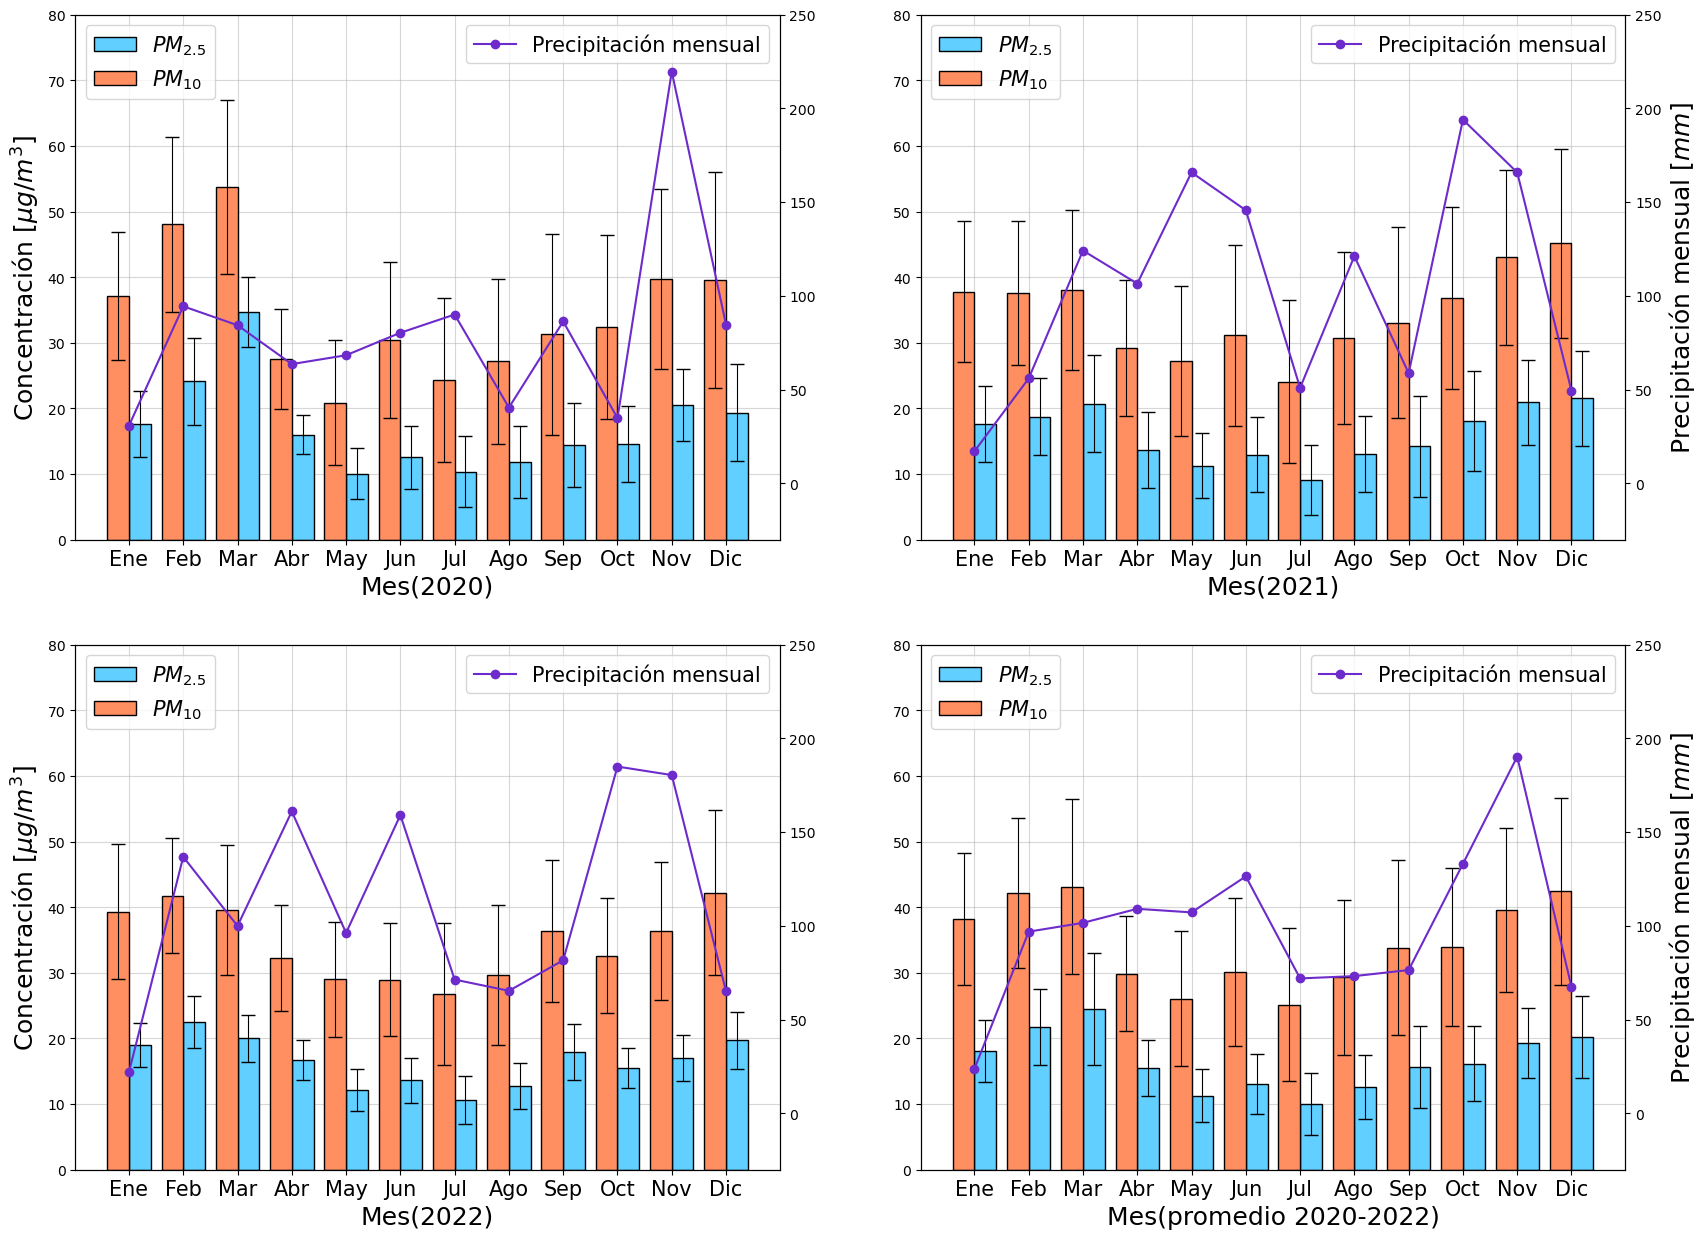

In [ ]:
# creamos los dataframes de cada año de forma mensual
datos_2020_mensual = promedio_estaciones(datos_2020, estaciones_2020, "M")["2020-01-01":"2020-12-31"].reset_index(drop=True)
datos_2021_mensual = promedio_estaciones(datos_2021, estaciones_2021, "M")["2021-01-01":"2021-12-31"].reset_index(drop=True)
datos_2022_mensual = promedio_estaciones(datos_2022, estaciones_2022, "M")["2022-01-01":"2022-12-31"].reset_index(drop=True)
precipitacion_2020_mensual = promedio_estaciones(precipitacion_2020, estaciones_precipitacion_2020, "M", "precipitacion")["2020-01-01":"2020-12-31"].reset_index(drop=True)
precipitacion_2021_mensual = promedio_estaciones(precipitacion_2021, estaciones_precipitacion_2021, "M", "precipitacion")["2021-01-01":"2021-12-31"].reset_index(drop=True)
precipitacion_2022_mensual = promedio_estaciones(precipitacion_2022, estaciones_precipitacion_2022, "M", "precipitacion")["2022-01-01":"2022-12-31"].reset_index(drop=True)

color_precipitacion = "#6e2bcb"
# realizamos la grafica de barras hecha en el punto anterior para cada año
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

#-----2020-----#
# graficamos los datos PM2.5 y PM10 con su desviación estándar
p1 = ax[0, 0].bar((datos_2020_mensual.index+1)+0.2, datos_2020_mensual["PM2.5"], color="#61cfff", edgecolor="black", label=r"$PM_{2.5}$", width=0.4)
p2 = ax[0, 0].bar((datos_2020_mensual.index+1)-0.2, datos_2020_mensual["PM10"], color="#ff8f61", edgecolor="black", label=r"$PM_{10}$", width=0.4)
ax[0, 0].errorbar((datos_2020_mensual.index+1+0.2), datos_2020_mensual["PM2.5"], yerr=datos_2020_mensual["PM2.5_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)
ax[0, 0].errorbar((datos_2020_mensual.index+1-0.2), datos_2020_mensual["PM10"], yerr=datos_2020_mensual["PM10_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)

# añadimos los labels
ax[0, 0].legend(fontsize=15, loc="upper left")
ax[0, 0].set_xlabel("Mes(2020)", fontsize=18)
ax[0, 0].set_ylabel(r"Concentración $[\mu g / m^3]$", fontsize=18)
ax[0, 0].set_ylim(0, 80)
ax[0, 0].set_xticks(np.arange(1, 13))
ax[0, 0].set_xticklabels(["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], fontsize=15)
ax[0, 0].grid(alpha=0.5)
ax[0, 0].set_axisbelow(True)

# graficamos el ratio
a = ax[0, 0].twinx() # creamos un segundo eje y
p3 = a.plot(precipitacion_2020_mensual.index+1, precipitacion_2020_mensual["Precipitacion"], "o-", color=color_precipitacion, label="Precipitación mensual")
# p3 = a.plot(datos_2020_mensual.index+1, datos_2020_mensual["PM2.5"]/datos_2020_mensual["PM10"], "o-", color="#71ff61", label=r"$PM_{2.5}/PM_{10}$")

# añadimos los labels
# ax[0, 0].set_ylabel(r"$PM_{2.5}/PM_{10}$", fontsize=18)
a.set_ylim(-30, 250)
a.legend(fontsize=15, loc="upper right")

#-----2021-----#
# graficamos los datos PM2.5 y PM10 con su desviación estándar
ax[0, 1].bar((datos_2021_mensual.index+1)+0.2, datos_2021_mensual["PM2.5"], color="#61cfff", edgecolor="black", label=r"$PM_{2.5}$", width=0.4)
ax[0, 1].bar((datos_2021_mensual.index+1)-0.2, datos_2021_mensual["PM10"], color="#ff8f61", edgecolor="black", label=r"$PM_{10}$", width=0.4)
ax[0, 1].errorbar((datos_2021_mensual.index+1+0.2), datos_2021_mensual["PM2.5"], yerr=datos_2021_mensual["PM2.5_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)
ax[0, 1].errorbar((datos_2021_mensual.index+1-0.2), datos_2021_mensual["PM10"], yerr=datos_2021_mensual["PM10_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)

# añadimos los labels
ax[0, 1].legend(fontsize=15, loc="upper left")
ax[0, 1].set_xlabel("Mes(2021)", fontsize=18)
# ax[0, 1].set_ylabel(r"Concentración $[\mu g / m^3]$", fontsize=18)
ax[0, 1].set_ylim(0, 80)
ax[0, 1].set_xticks(np.arange(1, 13))
ax[0, 1].set_xticklabels(["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], fontsize=15)
ax[0, 1].grid(alpha=0.5)
ax[0, 1].set_axisbelow(True)

# graficamos el ratio
b= ax[0, 1].twinx() # creamos un segundo eje y
b.plot(precipitacion_2021_mensual.index+1, precipitacion_2021_mensual["Precipitacion"], "o-", color=color_precipitacion, label="Precipitación mensual")
# b.plot(datos_2021_mensual.index+1, datos_2021_mensual["PM2.5"]/datos_2021_mensual["PM10"], "o-", color="#71ff61", label=r"$PM_{2.5}/PM_{10}$")

# añadimos los labels
b.set_ylabel("Precipitación mensual $[mm]$", fontsize=18)
# b.set_ylim(0.3, 0.65)
b.set_ylim(-30, 250)
b.legend(fontsize=15)

#-----2022-----#
# graficamos los datos PM2.5 y PM10 con su desviación estándar
ax[1, 0].bar((datos_2022_mensual.index+1)+0.2, datos_2022_mensual["PM2.5"], color="#61cfff", edgecolor="black", label=r"$PM_{2.5}$", width=0.4)
ax[1, 0].bar((datos_2022_mensual.index+1)-0.2, datos_2022_mensual["PM10"], color="#ff8f61", edgecolor="black", label=r"$PM_{10}$", width=0.4)
ax[1, 0].errorbar((datos_2022_mensual.index+1+0.2), datos_2022_mensual["PM2.5"], yerr=datos_2022_mensual["PM2.5_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)
ax[1, 0].errorbar((datos_2022_mensual.index+1-0.2), datos_2022_mensual["PM10"], yerr=datos_2022_mensual["PM10_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)

# añadimos los labels
ax[1, 0].legend(fontsize=15, loc="upper left")
ax[1, 0].set_xlabel("Mes(2022)", fontsize=18)
ax[1, 0].set_ylabel(r"Concentración $[\mu g / m^3]$", fontsize=18)
ax[1, 0].set_ylim(0, 80)
ax[1, 0].set_xticks(np.arange(1, 13))
ax[1, 0].set_xticklabels(["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], fontsize=15)
ax[1, 0].grid(alpha=0.5)
ax[1, 0].set_axisbelow(True)

# graficamos el ratio
c= ax[1, 0].twinx() # creamos un segundo eje y
c.plot(precipitacion_2022_mensual.index+1, precipitacion_2022_mensual["Precipitacion"], "o-", color=color_precipitacion, label="Precipitación mensual")
# c.plot(datos_2022_mensual.index+1, datos_2022_mensual["PM2.5"]/datos_2022_mensual["PM10"], "o-", color="#71ff61", label=r"$PM_{2.5}/PM_{10}$")

# añadimos los labels
# c.set_ylabel(r"$PM_{2.5}/PM_{10}$", fontsize=18)
# c.set_ylim(0.3, 0.65)
c.set_ylim(-30, 250)
# c.set_ylabel("Precipitación mensual $[mm]$", fontsize=18)
c.legend(fontsize=15, loc="upper right")

#-----Promedio-----#
# graficamos los datos PM2.5 y PM10 con su desviación estándar
ax[1, 1].bar((datos_mensual.index+1)+0.2, datos_mensual["PM2.5"], color="#61cfff", edgecolor="black", label=r"$PM_{2.5}$", width=0.4)
ax[1, 1].bar((datos_mensual.index+1)-0.2, datos_mensual["PM10"], color="#ff8f61", edgecolor="black", label=r"$PM_{10}$", width=0.4)
ax[1, 1].errorbar((datos_mensual.index+1+0.2), datos_mensual["PM2.5"], yerr=datos_mensual["PM2.5_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)
ax[1, 1].errorbar((datos_mensual.index+1-0.2), datos_mensual["PM10"], yerr=datos_mensual["PM10_std"], fmt="none", ecolor="black", capsize=5, linewidth=.8)

# añadimos los labels
ax[1, 1].legend(fontsize=15, loc="upper left")
ax[1, 1].set_xlabel("Mes(promedio 2020-2022)", fontsize=18)
# ax[1, 1].set_ylabel(r"Concentración $[\mu g / m^3]$", fontsize=18)
ax[1, 1].set_ylim(0, 80)
ax[1, 1].set_xticks(np.arange(1, 13))
ax[1, 1].set_xticklabels(["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], fontsize=15)
ax[1, 1].grid(alpha=0.5)
ax[1, 1].set_axisbelow(True)

# graficamos el ratio
d= ax[1, 1].twinx() # creamos un segundo eje y
d.plot(precipitacion_mensual.index+1, precipitacion_mensual["Precipitacion"], "o-", color=color_precipitacion, label="Precipitación mensual")
# d.plot(datos_mensual.index+1, datos_mensual["PM2.5"]/datos_mensual["PM10"], "o-", color="#71ff61", label=r"$PM_{2.5}/PM_{10}$")

# añadimos los labels
d.set_ylabel("Precipitación mensual $[mm]$", fontsize=18)
d.set_ylim(-30, 250)
# d.set_ylim(0.3, 0.65)
d.legend(fontsize=15, loc="upper right")

#-----Guardamos y mostramos-----#
# guardamos la figura
# fig.savefig("../data/results/comportamiento_mensual_anual_precipitacion.png", dpi=300, bbox_inches="tight")

# mostramos el gráfico
fig.show()


### Variación anual PM2.5/PM10 y Precipitación

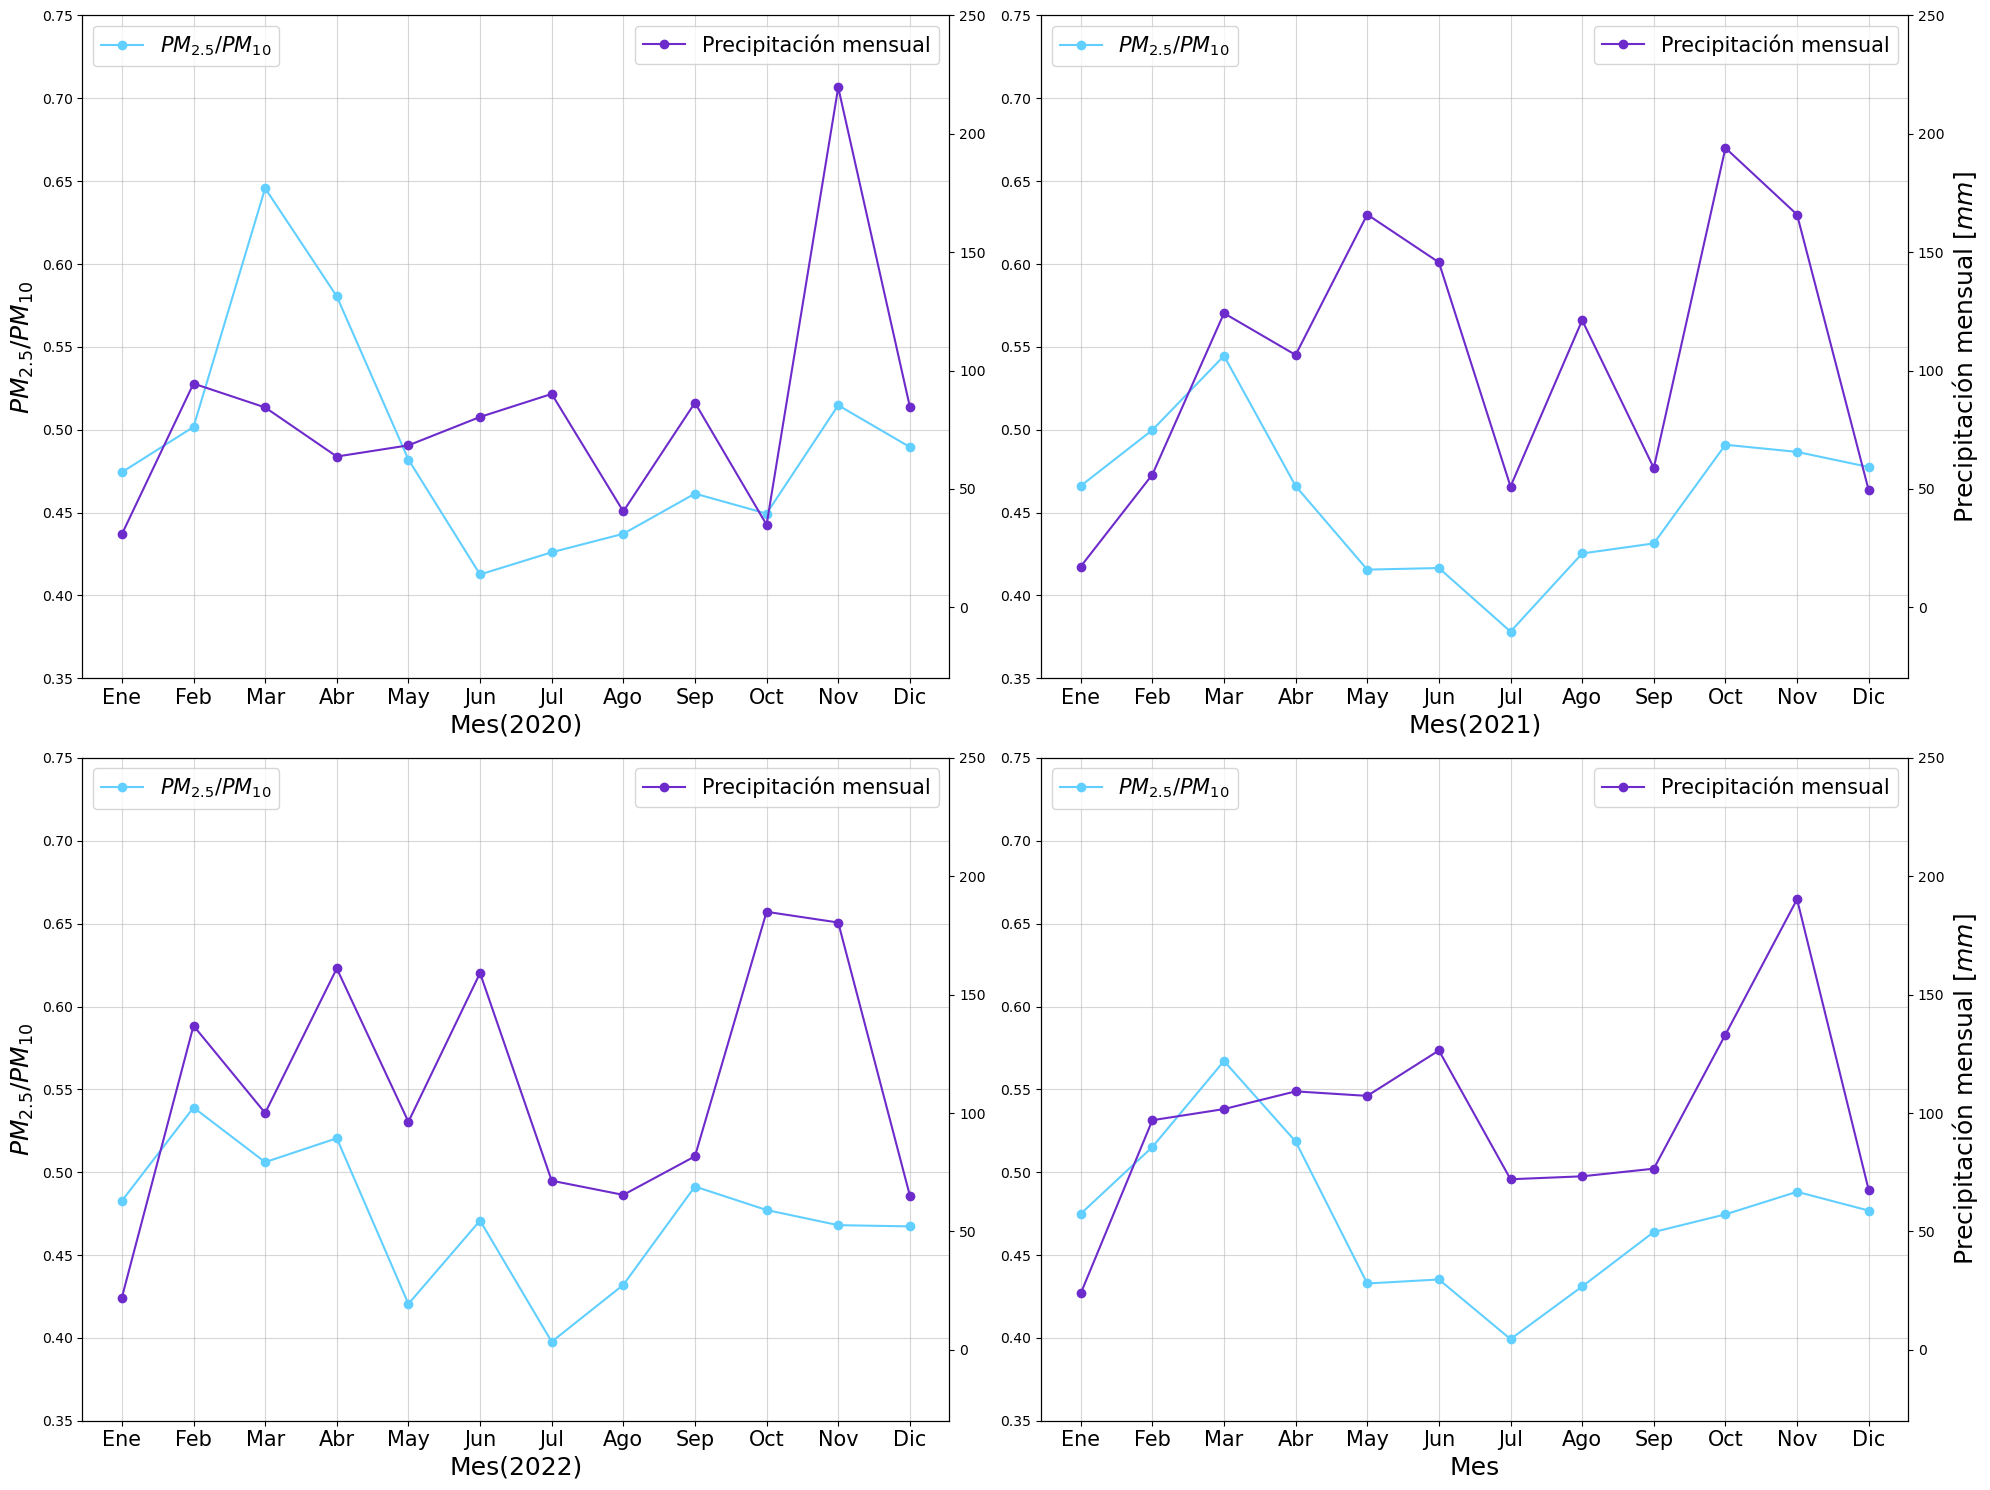

In [ ]:
# Graficas de ratio PM2.5/PM10 vs precipitación mensual
#-----Creamos la figura-----#
fig, ax= plt.subplots(2, 2, figsize=(20, 15))

#-----2020-----#
# graficamos los datos ratio y precipitacion
ax[0,0].plot(datos_2020_mensual.index+1, datos_2020_mensual["PM2.5"]/datos_2020_mensual["PM10"], "o-", color="#61cfff", label=r"$PM_{2.5}/PM_{10}$")
ax1 = ax[0,0].twinx() # creamos un segundo eje y
ax1.plot(precipitacion_2020_mensual.index+1, precipitacion_2020_mensual["Precipitacion"], "o-", color=color_precipitacion, label="Precipitación mensual")

# añadimos los labels
ax[0,0].legend(fontsize=15, loc="upper left")
ax1.legend(fontsize=15, loc="upper right")
ax[0,0].set_xlabel("Mes(2020)", fontsize=18)
ax[0,0].set_ylabel(r"$PM_{2.5}/PM_{10}$", fontsize=18)
ax[0,0].set_ylim(0.35, 0.75)
# ax1.set_ylabel("Precipitación mensual $[mm]$", fontsize=18)
ax1.set_ylim(-30, 250)
ax[0,0].set_xticks(np.arange(1, 13))
ax[0,0].set_xticklabels(["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], fontsize=15)
ax[0,0].grid(alpha=0.5)
ax[0,0].set_axisbelow(True)

#-----2021-----#
# graficamos los datos ratio y precipitacion
ax[0,1].plot(datos_2021_mensual.index+1, datos_2021_mensual["PM2.5"]/datos_2021_mensual["PM10"], "o-", color="#61cfff", label=r"$PM_{2.5}/PM_{10}$")
ax1 = ax[0,1].twinx() # creamos un segundo eje y
ax1.plot(precipitacion_2021_mensual.index+1, precipitacion_2021_mensual["Precipitacion"], "o-", color=color_precipitacion, label="Precipitación mensual")

# añadimos los labels
ax[0,1].legend(fontsize=15, loc="upper left")
ax1.legend(fontsize=15, loc="upper right")
ax[0,1].set_xlabel("Mes(2021)", fontsize=18)
# ax[0,1].set_ylabel(r"$PM_{2.5}/PM_{10}$", fontsize=18)
ax[0,1].set_ylim(0.35, 0.75)
ax1.set_ylabel("Precipitación mensual $[mm]$", fontsize=18)
ax1.set_ylim(-30, 250)
ax[0,1].set_xticks(np.arange(1, 13))
ax[0,1].set_xticklabels(["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], fontsize=15)
ax[0,1].grid(alpha=0.5)
ax[0,1].set_axisbelow(True)

#-----2022-----#
# graficamos los datos ratio y precipitacion
ax[1,0].plot(datos_2022_mensual.index+1, datos_2022_mensual["PM2.5"]/datos_2022_mensual["PM10"], "o-", color="#61cfff", label=r"$PM_{2.5}/PM_{10}$")
ax1 = ax[1,0].twinx() # creamos un segundo eje y
ax1.plot(precipitacion_2022_mensual.index+1, precipitacion_2022_mensual["Precipitacion"], "o-", color=color_precipitacion, label="Precipitación mensual")

# añadimos los labels
ax[1,0].legend(fontsize=15, loc="upper left")
ax1.legend(fontsize=15, loc="upper right")
ax[1,0].set_xlabel("Mes(2022)", fontsize=18)
ax[1,0].set_ylabel(r"$PM_{2.5}/PM_{10}$", fontsize=18)
ax[1,0].set_ylim(0.35, 0.75)
# ax1.set_ylabel("Precipitación mensual $[mm]$", fontsize=18)
ax1.set_ylim(-30, 250)
ax[1,0].set_xticks(np.arange(1, 13))
ax[1,0].set_xticklabels(["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], fontsize=15)
ax[1,0].grid(alpha=0.5)
ax[1,0].set_axisbelow(True)

#-----Periodo-----#
# graficamos los datos ratio y precipitacion
ax[1,1].plot(datos_mensual.index+1, datos_mensual["PM2.5"]/datos_mensual["PM10"], "o-", color="#61cfff", label=r"$PM_{2.5}/PM_{10}$")
ax1 = ax[1,1].twinx() # creamos un segundo eje y
ax1.plot(precipitacion_mensual.index+1, precipitacion_mensual["Precipitacion"], "o-", color=color_precipitacion, label="Precipitación mensual")

# añadimos los labels
ax[1,1].legend(fontsize=15, loc="upper left")
ax1.legend(fontsize=15, loc="upper right")
ax[1,1].set_xlabel("Mes", fontsize=18)
# ax[1,1].set_ylabel(r"$PM_{2.5}/PM_{10}$", fontsize=18)
ax[1,1].set_ylim(0.35, 0.75)
ax1.set_ylabel("Precipitación mensual $[mm]$", fontsize=18)
ax1.set_ylim(-30, 250)
ax[1,1].set_xticks(np.arange(1, 13))
ax[1,1].set_xticklabels(["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], fontsize=15)
ax[1,1].grid(alpha=0.5)
ax[1,1].set_axisbelow(True)

plt.tight_layout()
# plt.savefig("../data/results/ratio_precipitacion_mensual.png", dpi=300)

plt.show()

### Regresiones y correlaciones PM2.5, PM10, PM2.5/PM10 y Precipitación

#### PM2.5/PM10 y Precipitación 

In [ ]:
# correlaciones entre ratio y precipitacion
print("Correlación entre ratio y precipitación")
print("2020: ", datos_2020_mensual["PM2.5"].corr(precipitacion_2020_mensual["Precipitacion"]))
print("2021: ", datos_2021_mensual["PM2.5"].corr(precipitacion_2021_mensual["Precipitacion"]))
print("2022: ", datos_2022_mensual["PM2.5"].corr(precipitacion_2022_mensual["Precipitacion"]))
print("Periodo: ", datos_mensual["PM2.5"].corr(precipitacion_mensual["Precipitacion"]))


Correlación entre ratio y precipitación
2020:  0.25801852948285275
2021:  -0.005854662896441933
2022:  0.006219962219484759
Periodo:  0.07993460969872684


Realizamos una regresión lineal entre la precipitación y el ratio PM2.5/PM10 diarios

In [ ]:
# guardamos la precipitacion diaria
precipitacion_2020_promedio = promedio_estaciones(precipitacion_2020, estaciones_precipitacion_2020, "D", "precipitacion")
precipitacion_2021_promedio = promedio_estaciones(precipitacion_2021, estaciones_precipitacion_2021, "D", "precipitacion")
precipitacion_2022_promedio = promedio_estaciones(precipitacion_2022, estaciones_precipitacion_2022, "D", "precipitacion")

# hacemos las regresiones (polyfit)
regresiones_2020_precipitacion = np.polyfit(precipitacion_2020_promedio["Precipitacion"], datos_2020_promedio["ratio"]["2020-01-01":"2020-12-31"],1)
regresiones_2021_precipitacion = np.polyfit(precipitacion_2021_promedio["Precipitacion"], datos_2021_promedio["ratio"]["2021-01-01":"2021-12-31"],1)
regresiones_2022_precipitacion = np.polyfit(precipitacion_2022_promedio["Precipitacion"], datos_2022_promedio["ratio"]["2022-01-01":"2022-12-31"],1)

Graficamos los datos con sus respectivas regresiones lineales y sus coeficientes de correlación

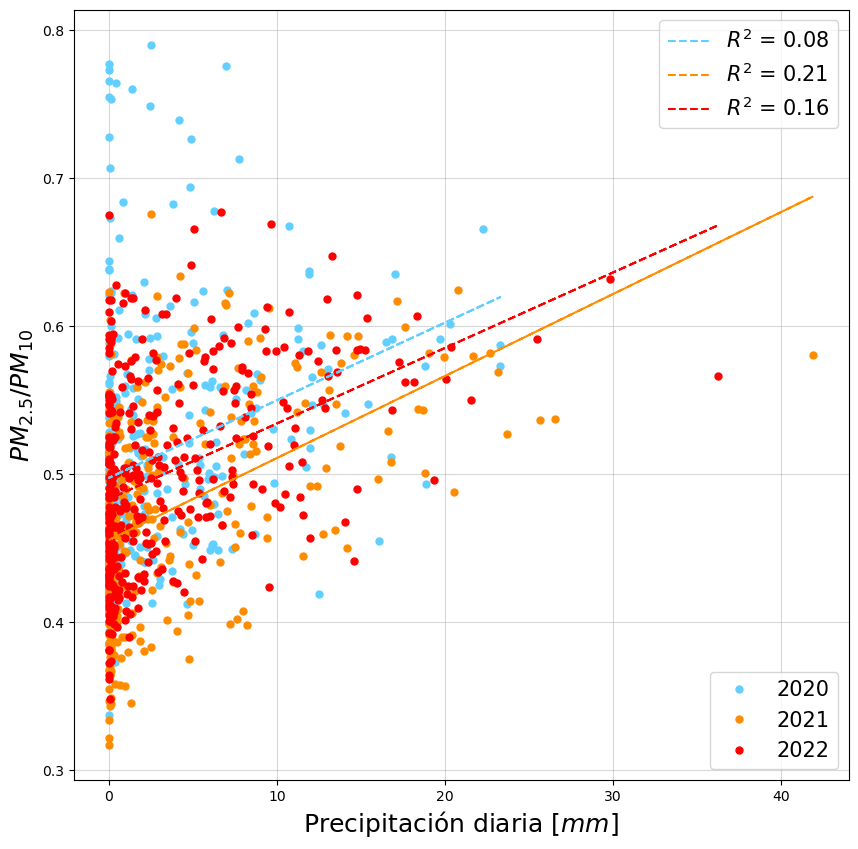

In [ ]:
# creamos la figura
fig, ax = plt.subplots(figsize=(10, 10))

# graficamos los datos ratio y precipitacion
ax.plot(precipitacion_2020_promedio["Precipitacion"], datos_2020_promedio["ratio"]["2020-01-01":"2020-12-31"], "o", color="#61cfff", label=r"2020", markersize=5)
ax.plot(precipitacion_2021_promedio["Precipitacion"], datos_2021_promedio["ratio"]["2021-01-01":"2021-12-31"], "o", color="#ff8c00", label=r"2021", markersize=5)
ax.plot(precipitacion_2022_promedio["Precipitacion"], datos_2022_promedio["ratio"]["2022-01-01":"2022-12-31"], "o", color="#ff0000", label=r"2022", markersize=5)

# graficamos las regresiones
line_2020, = ax.plot(precipitacion_2020_promedio["Precipitacion"], regresiones_2020_precipitacion[0]*precipitacion_2020_promedio["Precipitacion"]+regresiones_2020_precipitacion[1], color="#61cfff", linestyle="--")
line_2021, = ax.plot(precipitacion_2021_promedio["Precipitacion"], regresiones_2021_precipitacion[0]*precipitacion_2021_promedio["Precipitacion"]+regresiones_2021_precipitacion[1], color="#ff8c00", linestyle="--")
line_2022, = ax.plot(precipitacion_2022_promedio["Precipitacion"], regresiones_2022_precipitacion[0]*precipitacion_2022_promedio["Precipitacion"]+regresiones_2022_precipitacion[1], color="#ff0000", linestyle="--")

# añadimos los labels
f_leg = ax.legend(fontsize=15, loc="lower right")
fig.add_artist(f_leg)
ax.legend(fontsize=15, loc="upper right",
          handles=[line_2020, line_2021, line_2022],
          labels=[f"$R^2$ = {round(np.corrcoef(precipitacion_2020_promedio['Precipitacion'], datos_2020_promedio['ratio']['2020-01-01':'2020-12-31'])[0,1]**2, 2)}",
                  f"$R^2$ = {round(np.corrcoef(precipitacion_2021_promedio['Precipitacion'], datos_2021_promedio['ratio']['2021-01-01':'2021-12-31'])[0,1]**2, 2)}",
                  f"$R^2$ = {round(np.corrcoef(precipitacion_2022_promedio['Precipitacion'], datos_2022_promedio['ratio']['2022-01-01':'2022-12-31'])[0,1]**2, 2)}"])
ax.set_xlabel("Precipitación diaria $[mm]$", fontsize=18)
ax.set_ylabel(r"$PM_{2.5}/PM_{10}$", fontsize=18)
# ax.set_ylim(0.35, 0.75)
ax.grid(alpha=0.5)
ax.set_axisbelow(True)
plt.show()

fig.savefig("../data/results/correlacion_ratio_precipitacion_dia.png", dpi=300)

Realizamos el mismo procedimiento pero con datos por hora

In [ ]:
# guardamos el material particulado diario
datos_2020_promedio_H = promedio_estaciones(datos_2020, estaciones_2020, "H")
datos_2021_promedio_H = promedio_estaciones(datos_2021, estaciones_2021, "H")
datos_2022_promedio_H = promedio_estaciones(datos_2022, estaciones_2022, "H")

# guardamos la precipitacion diaria
precipitacion_2020_promedio_H = promedio_estaciones(precipitacion_2020, estaciones_precipitacion_2020, "H", "precipitacion")
precipitacion_2021_promedio_H = promedio_estaciones(precipitacion_2021, estaciones_precipitacion_2021, "H", "precipitacion")
precipitacion_2022_promedio_H = promedio_estaciones(precipitacion_2022, estaciones_precipitacion_2022, "H", "precipitacion")

# hacemos merges para obtener las fechas y horas donde hay datos de precipitacion y material particulado
datos_precipitacion_2020_H = pd.merge(datos_2020_promedio_H, precipitacion_2020_promedio_H, how="inner", left_index=True, right_index=True)
datos_precipitacion_2021_H = pd.merge(datos_2021_promedio_H, precipitacion_2021_promedio_H, how="inner", left_index=True, right_index=True)
datos_precipitacion_2022_H = pd.merge(datos_2022_promedio_H, precipitacion_2022_promedio_H, how="inner", left_index=True, right_index=True)

# hacemos las regresiones (polyfit)
regresiones_2020_precipitacion_H = np.polyfit(datos_precipitacion_2020_H["Precipitacion"], datos_precipitacion_2020_H["ratio"],1)
regresiones_2021_precipitacion_H = np.polyfit(datos_precipitacion_2021_H["Precipitacion"], datos_precipitacion_2021_H["ratio"],1)
regresiones_2022_precipitacion_H = np.polyfit(datos_precipitacion_2022_H["Precipitacion"], datos_precipitacion_2022_H["ratio"],1)


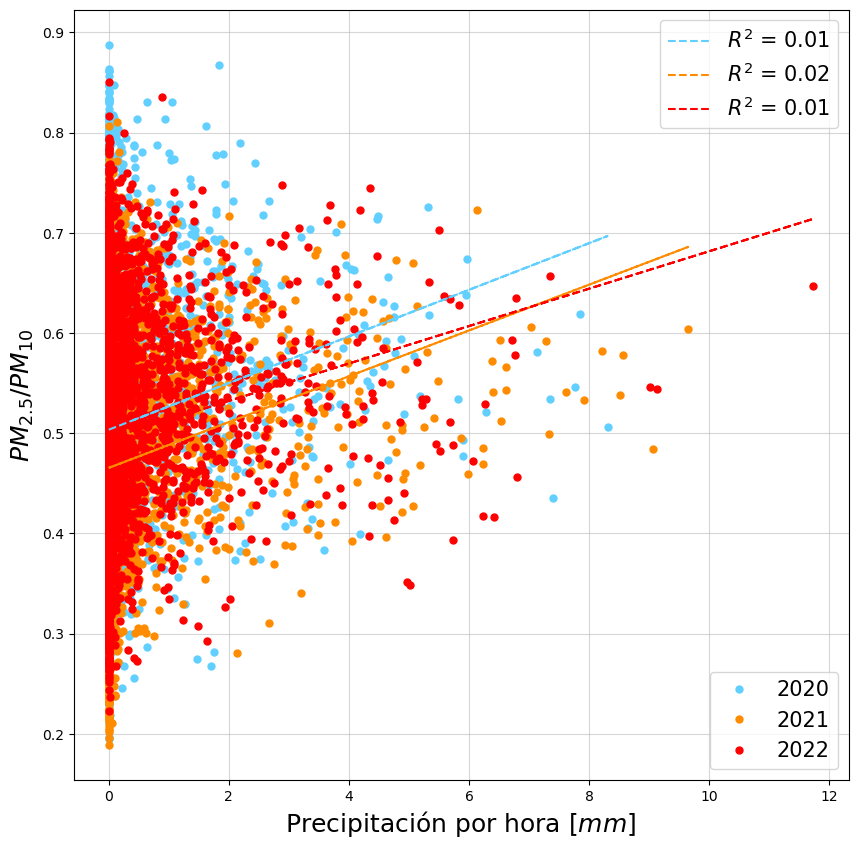

In [ ]:
# creamos la figura
fig, ax = plt.subplots(figsize=(10, 10))

# graficamos los datos ratio y precipitacion
ax.plot(datos_precipitacion_2020_H["Precipitacion"], datos_precipitacion_2020_H["ratio"], "o", color="#61cfff", label=r"2020", markersize=5)
ax.plot(datos_precipitacion_2021_H["Precipitacion"], datos_precipitacion_2021_H["ratio"], "o", color="#ff8c00", label=r"2021", markersize=5)
ax.plot(datos_precipitacion_2022_H["Precipitacion"], datos_precipitacion_2022_H["ratio"], "o", color="#ff0000", label=r"2022", markersize=5)

# graficamos las regresiones
line_2020, = ax.plot(datos_precipitacion_2020_H["Precipitacion"], regresiones_2020_precipitacion_H[0]*datos_precipitacion_2020_H["Precipitacion"]+regresiones_2020_precipitacion_H[1], color="#61cfff", linestyle="--")
line_2021, = ax.plot(datos_precipitacion_2021_H["Precipitacion"], regresiones_2021_precipitacion_H[0]*datos_precipitacion_2021_H["Precipitacion"]+regresiones_2021_precipitacion_H[1], color="#ff8c00", linestyle="--")
line_2022, = ax.plot(datos_precipitacion_2022_H["Precipitacion"], regresiones_2022_precipitacion_H[0]*datos_precipitacion_2022_H["Precipitacion"]+regresiones_2022_precipitacion_H[1], color="#ff0000", linestyle="--")

# añadimos los labels
f_leg = ax.legend(fontsize=15, loc="lower right")
fig.add_artist(f_leg)
ax.legend(fontsize=15, loc="upper right",
          handles=[line_2020, line_2021, line_2022],
          labels=[f"$R^2$ = {round(np.corrcoef(datos_precipitacion_2020_H['Precipitacion'], datos_precipitacion_2020_H['ratio'])[0,1]**2, 2)}",
                  f"$R^2$ = {round(np.corrcoef(datos_precipitacion_2021_H['Precipitacion'], datos_precipitacion_2021_H['ratio'])[0,1]**2, 2)}",
                  f"$R^2$ = {round(np.corrcoef(datos_precipitacion_2022_H['Precipitacion'], datos_precipitacion_2022_H['ratio'])[0,1]**2, 2)}"])
ax.set_xlabel("Precipitación por hora $[mm]$", fontsize=18)
ax.set_ylabel(r"$PM_{2.5}/PM_{10}$", fontsize=18)
# ax.set_ylim(0.35, 0.75)
ax.grid(alpha=0.5)
ax.set_axisbelow(True)
plt.show()

fig.savefig("../data/results/correlacion_ratio_precipitacion_hora.png", dpi=300)

#### PM10 y Precipitación

Realizamos una regresión lineal entre la precipitación y el PM10 diarios

In [ ]:
# hacemos las regresiones (polyfit)
regresiones_2020_precipitacion_PM10 = np.polyfit(precipitacion_2020_promedio["Precipitacion"], datos_2020_promedio["PM10"]["2020-01-01":"2020-12-31"],1)
regresiones_2021_precipitacion_PM10 = np.polyfit(precipitacion_2021_promedio["Precipitacion"], datos_2021_promedio["PM10"]["2021-01-01":"2021-12-31"],1)
regresiones_2022_precipitacion_PM10 = np.polyfit(precipitacion_2022_promedio["Precipitacion"], datos_2022_promedio["PM10"]["2022-01-01":"2022-12-31"],1)

Graficamos los datos con sus respectivas regresiones lineales y sus coeficientes de correlación

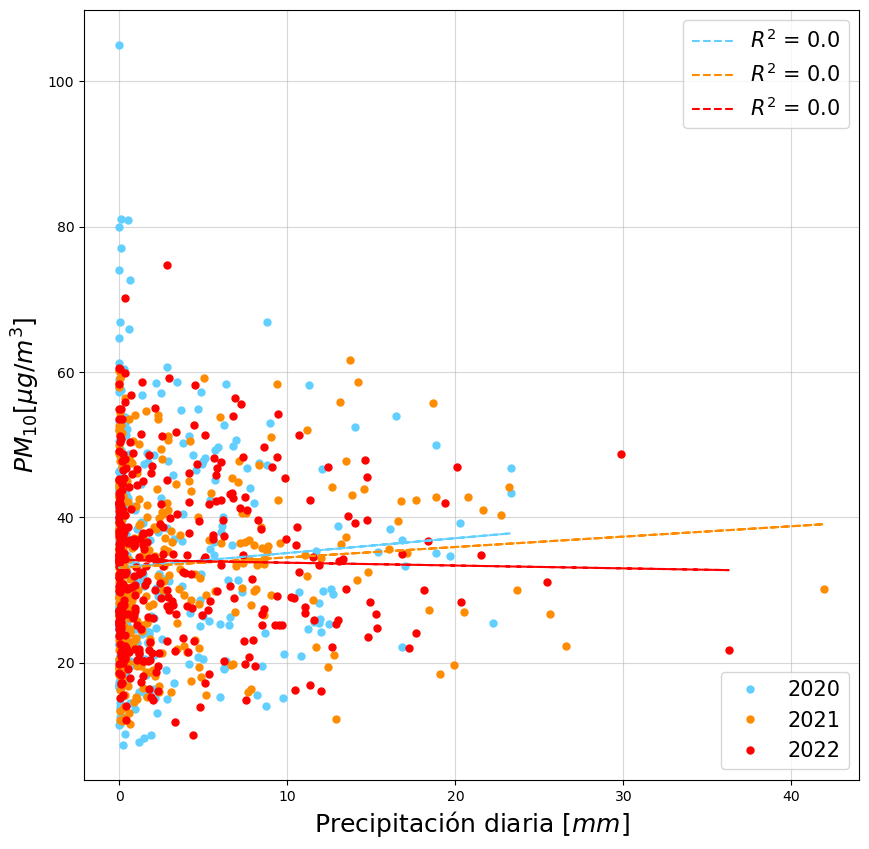

In [ ]:
# creamos la figura
fig, ax = plt.subplots(figsize=(10, 10))

# graficamos los datos ratio y precipitacion
ax.plot(precipitacion_2020_promedio["Precipitacion"], datos_2020_promedio["PM10"]["2020-01-01":"2020-12-31"], "o", color="#61cfff", label=r"2020", markersize=5)
ax.plot(precipitacion_2021_promedio["Precipitacion"], datos_2021_promedio["PM10"]["2021-01-01":"2021-12-31"], "o", color="#ff8c00", label=r"2021", markersize=5)
ax.plot(precipitacion_2022_promedio["Precipitacion"], datos_2022_promedio["PM10"]["2022-01-01":"2022-12-31"], "o", color="#ff0000", label=r"2022", markersize=5)

# graficamos las regresiones
line_2020, = ax.plot(precipitacion_2020_promedio["Precipitacion"], regresiones_2020_precipitacion_PM10[0]*precipitacion_2020_promedio["Precipitacion"]+regresiones_2020_precipitacion_PM10[1], color="#61cfff", linestyle="--")
line_2021, = ax.plot(precipitacion_2021_promedio["Precipitacion"], regresiones_2021_precipitacion_PM10[0]*precipitacion_2021_promedio["Precipitacion"]+regresiones_2021_precipitacion_PM10[1], color="#ff8c00", linestyle="--")
line_2022, = ax.plot(precipitacion_2022_promedio["Precipitacion"], regresiones_2022_precipitacion_PM10[0]*precipitacion_2022_promedio["Precipitacion"]+regresiones_2022_precipitacion_PM10[1], color="#ff0000", linestyle="--")

# añadimos los labels
f_leg = ax.legend(fontsize=15, loc="lower right")
fig.add_artist(f_leg)
ax.legend(fontsize=15, loc="upper right",
          handles=[line_2020, line_2021, line_2022],
          labels=[f"$R^2$ = {round(np.corrcoef(precipitacion_2020_promedio['Precipitacion'], datos_2020_promedio['PM10']['2020-01-01':'2020-12-31'])[0,1]**2, 2)}",
                  f"$R^2$ = {round(np.corrcoef(precipitacion_2021_promedio['Precipitacion'], datos_2021_promedio['PM10']['2021-01-01':'2021-12-31'])[0,1]**2, 2)}",
                  f"$R^2$ = {round(np.corrcoef(precipitacion_2022_promedio['Precipitacion'], datos_2022_promedio['PM10']['2022-01-01':'2022-12-31'])[0,1]**2, 2)}"])
ax.set_xlabel("Precipitación diaria $[mm]$", fontsize=18)
ax.set_ylabel(r"$PM_{10} [\mu g / m^3]$", fontsize=18)
# ax.set_ylim(0.35, 0.75)
ax.grid(alpha=0.5)
ax.set_axisbelow(True)
plt.show()

fig.savefig("../data/results/correlacion_PM10_precipitacion.png", dpi=300)

#### PM2.5 y Precipitación

Realizamos una regresión lineal entre la precipitación y el PM2.5 diarios

In [ ]:
# hacemos las regresiones (polyfit)
regresiones_2020_precipitacion_PM25 = np.polyfit(precipitacion_2020_promedio["Precipitacion"], datos_2020_promedio["PM2.5"]["2020-01-01":"2020-12-31"],1)
regresiones_2021_precipitacion_PM25 = np.polyfit(precipitacion_2021_promedio["Precipitacion"], datos_2021_promedio["PM2.5"]["2021-01-01":"2021-12-31"],1)
regresiones_2022_precipitacion_PM25 = np.polyfit(precipitacion_2022_promedio["Precipitacion"], datos_2022_promedio["PM2.5"]["2022-01-01":"2022-12-31"],1)

Graficamos los datos con sus respectivas regresiones lineales y sus coeficientes de correlación

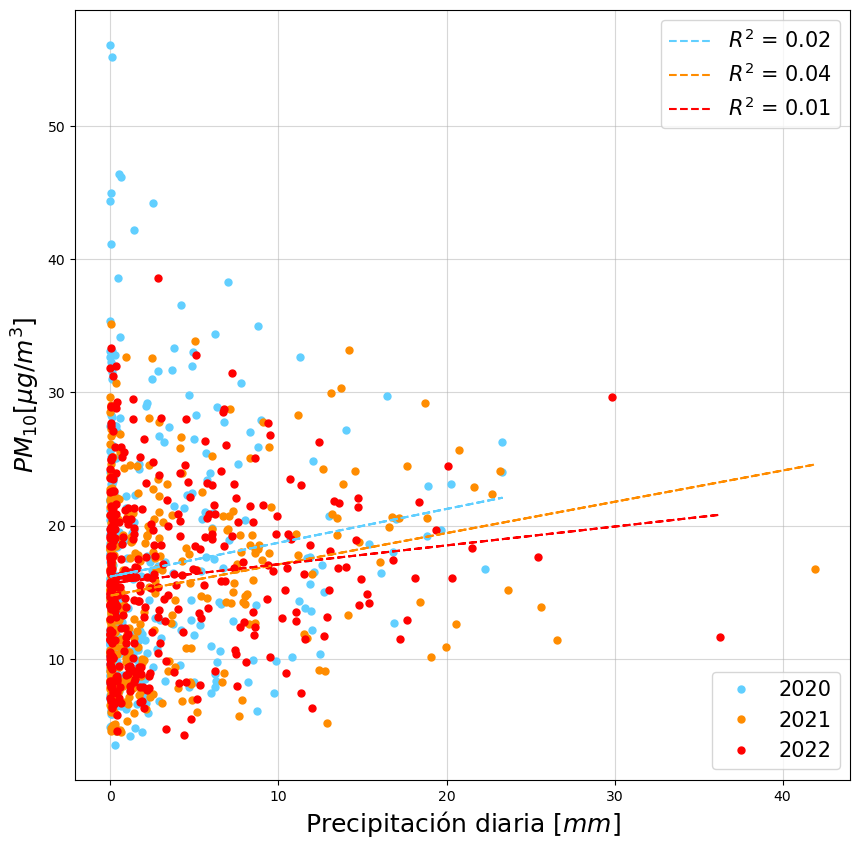

In [ ]:
# creamos la figura
fig, ax = plt.subplots(figsize=(10, 10))

# graficamos los datos ratio y precipitacion
ax.plot(precipitacion_2020_promedio["Precipitacion"], datos_2020_promedio["PM2.5"]["2020-01-01":"2020-12-31"], "o", color="#61cfff", label=r"2020", markersize=5)
ax.plot(precipitacion_2021_promedio["Precipitacion"], datos_2021_promedio["PM2.5"]["2021-01-01":"2021-12-31"], "o", color="#ff8c00", label=r"2021", markersize=5)
ax.plot(precipitacion_2022_promedio["Precipitacion"], datos_2022_promedio["PM2.5"]["2022-01-01":"2022-12-31"], "o", color="#ff0000", label=r"2022", markersize=5)

# graficamos las regresiones
line_2020, = ax.plot(precipitacion_2020_promedio["Precipitacion"], regresiones_2020_precipitacion_PM25[0]*precipitacion_2020_promedio["Precipitacion"]+regresiones_2020_precipitacion_PM25[1], color="#61cfff", linestyle="--")
line_2021, = ax.plot(precipitacion_2021_promedio["Precipitacion"], regresiones_2021_precipitacion_PM25[0]*precipitacion_2021_promedio["Precipitacion"]+regresiones_2021_precipitacion_PM25[1], color="#ff8c00", linestyle="--")
line_2022, = ax.plot(precipitacion_2022_promedio["Precipitacion"], regresiones_2022_precipitacion_PM25[0]*precipitacion_2022_promedio["Precipitacion"]+regresiones_2022_precipitacion_PM25[1], color="#ff0000", linestyle="--")

# añadimos los labels
f_leg = ax.legend(fontsize=15, loc="lower right")
fig.add_artist(f_leg)
ax.legend(fontsize=15, loc="upper right",
          handles=[line_2020, line_2021, line_2022],
          labels=[f"$R^2$ = {round(np.corrcoef(precipitacion_2020_promedio['Precipitacion'], datos_2020_promedio['PM2.5']['2020-01-01':'2020-12-31'])[0,1]**2, 2)}",
                  f"$R^2$ = {round(np.corrcoef(precipitacion_2021_promedio['Precipitacion'], datos_2021_promedio['PM2.5']['2021-01-01':'2021-12-31'])[0,1]**2, 2)}",
                  f"$R^2$ = {round(np.corrcoef(precipitacion_2022_promedio['Precipitacion'], datos_2022_promedio['PM2.5']['2022-01-01':'2022-12-31'])[0,1]**2, 2)}"])
ax.set_xlabel("Precipitación diaria $[mm]$", fontsize=18)
ax.set_ylabel(r"$PM_{10} [\mu g / m^3]$", fontsize=18)
# ax.set_ylim(0.35, 0.75)
ax.grid(alpha=0.5)
ax.set_axisbelow(True)
plt.show()

fig.savefig("../data/results/correlacion_PM25_precipitacion.png", dpi=300, bbox_inches="tight")

### Regresion y variacion temporal por estación

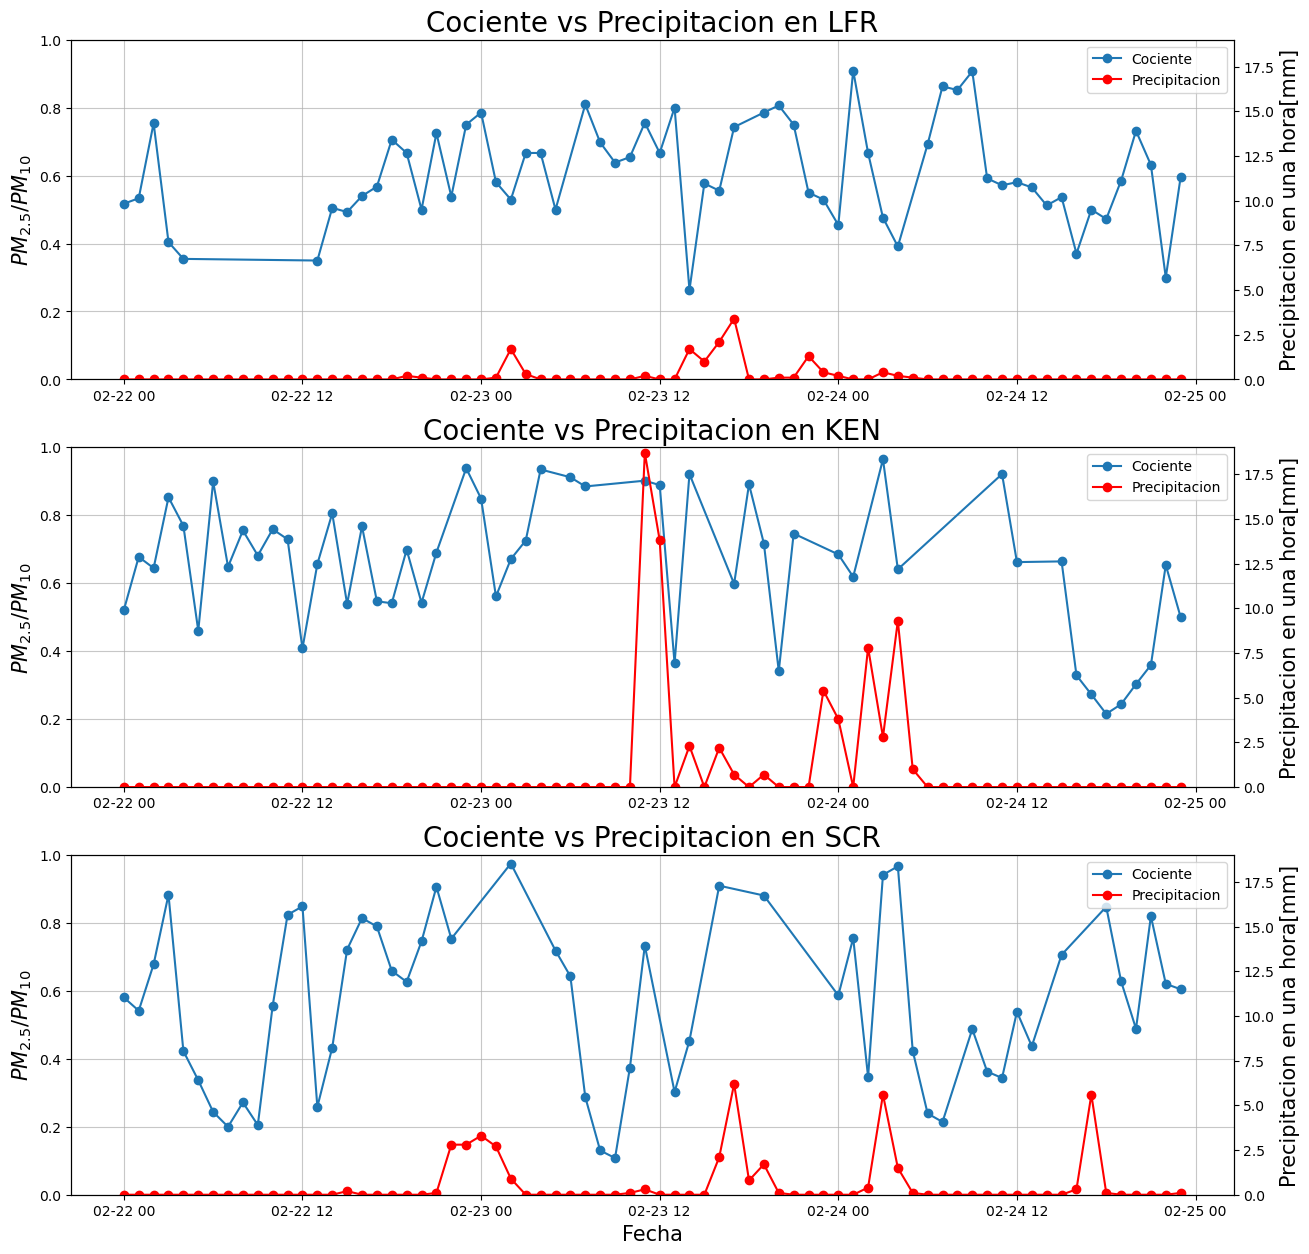

In [ ]:
# Generamos la figura
fig, ax = plt.subplots(3,figsize=(15, 15))

#-----LFR-----#
a1, = ax[0].plot(datos_2020["LFR"]["ratio"]["2020-02-22 00:00:00":"2020-02-24 23:00:00"], "o-", label="Cociente")
ax[0].set_ylim(0, 1)
ax[0].set_ylabel(r"$PM_{2.5}/PM_{10}$", fontsize=15)
ax[0].set_title("Cociente vs Precipitacion en LFR", fontsize=20)
ax[0].grid(alpha=0.7)
a = ax[0].twinx()
a2, = a.plot(precipitacion_2020["LFR"]["2020-02-22 00:00:00":"2020-02-24 23:00:00"], "o-", color="red", label="Precipitacion")
a.set_ylabel("Precipitacion en una hora[mm]", fontsize=15)
a.set_ylim(0, 19)
a.legend(handles=[a1, a2])

#-----KEN-----#
b1, = ax[1].plot(datos_2020["KEN"]["ratio"]["2020-02-22 00:00:00":"2020-02-24 23:00:00"], "o-", label="Cociente")
ax[1].set_ylim(0, 1)
ax[1].set_ylabel(r"$PM_{2.5}/PM_{10}$", fontsize=15)
ax[1].set_title("Cociente vs Precipitacion en KEN", fontsize=20)
ax[1].grid(alpha=0.7)
b = ax[1].twinx()
b2, = b.plot(precipitacion_2020["KEN"]["2020-02-22 00:00:00":"2020-02-24 23:00:00"], "o-", color="red", label="Precipitacion")
b.set_ylabel("Precipitacion en una hora[mm]", fontsize=15)
b.set_ylim(0, 19)
b.legend(handles=[b1, b2])

#-----SCR-----#
c1, = ax[2].plot(datos_2020["SCR"]["ratio"]["2020-02-22 00:00:00":"2020-02-24 23:00:00"], "o-", label="Cociente")
ax[2].set_ylim(0, 1)
ax[2].set_ylabel(r"$PM_{2.5}/PM_{10}$", fontsize=15)
ax[2].set_xlabel("Fecha", fontsize=15)
ax[2].set_title("Cociente vs Precipitacion en SCR", fontsize=20)
ax[2].grid(alpha=0.7)
c = ax[2].twinx()
c2, = c.plot(precipitacion_2020["SCR"]["2020-02-22 00:00:00":"2020-02-24 23:00:00"], "o-", color="red", label="Precipitacion")
c.set_ylabel("Precipitacion en una hora[mm]", fontsize=15)
c.set_ylim(0, 19)
c.legend(handles=[c1, c2])

In [ ]:
# Realizamos un merge con los datos de ratio y precipitación para realizar la regresion
datos_LFR = pd.merge(datos_2020["LFR"]["ratio"]["2020-02-22 00:00:00":"2020-02-24 23:00:00"], precipitacion_2020["LFR"]["2020-02-22 00:00:00":"2020-02-24 23:00:00"], how='inner', left_index=True, right_index=True)
datos_KEN = pd.merge(datos_2020["KEN"]["ratio"]["2020-02-22 00:00:00":"2020-02-24 23:00:00"], precipitacion_2020["KEN"]["2020-02-22 00:00:00":"2020-02-24 23:00:00"], how='inner', left_index=True, right_index=True)
datos_SCR = pd.merge(datos_2020["SCR"]["ratio"]["2020-02-22 00:00:00":"2020-02-24 23:00:00"], precipitacion_2020["SCR"]["2020-02-22 00:00:00":"2020-02-24 23:00:00"], how='inner', left_index=True, right_index=True)

# realizamos las regresiones
regresion_LFR = np.polyfit(datos_LFR["Precipitacion"], datos_LFR["ratio"], 1)
regresion_KEN = np.polyfit(datos_KEN["Precipitacion"], datos_KEN["ratio"], 1)
regresion_SCR = np.polyfit(datos_SCR["Precipitacion"], datos_SCR["ratio"], 1)

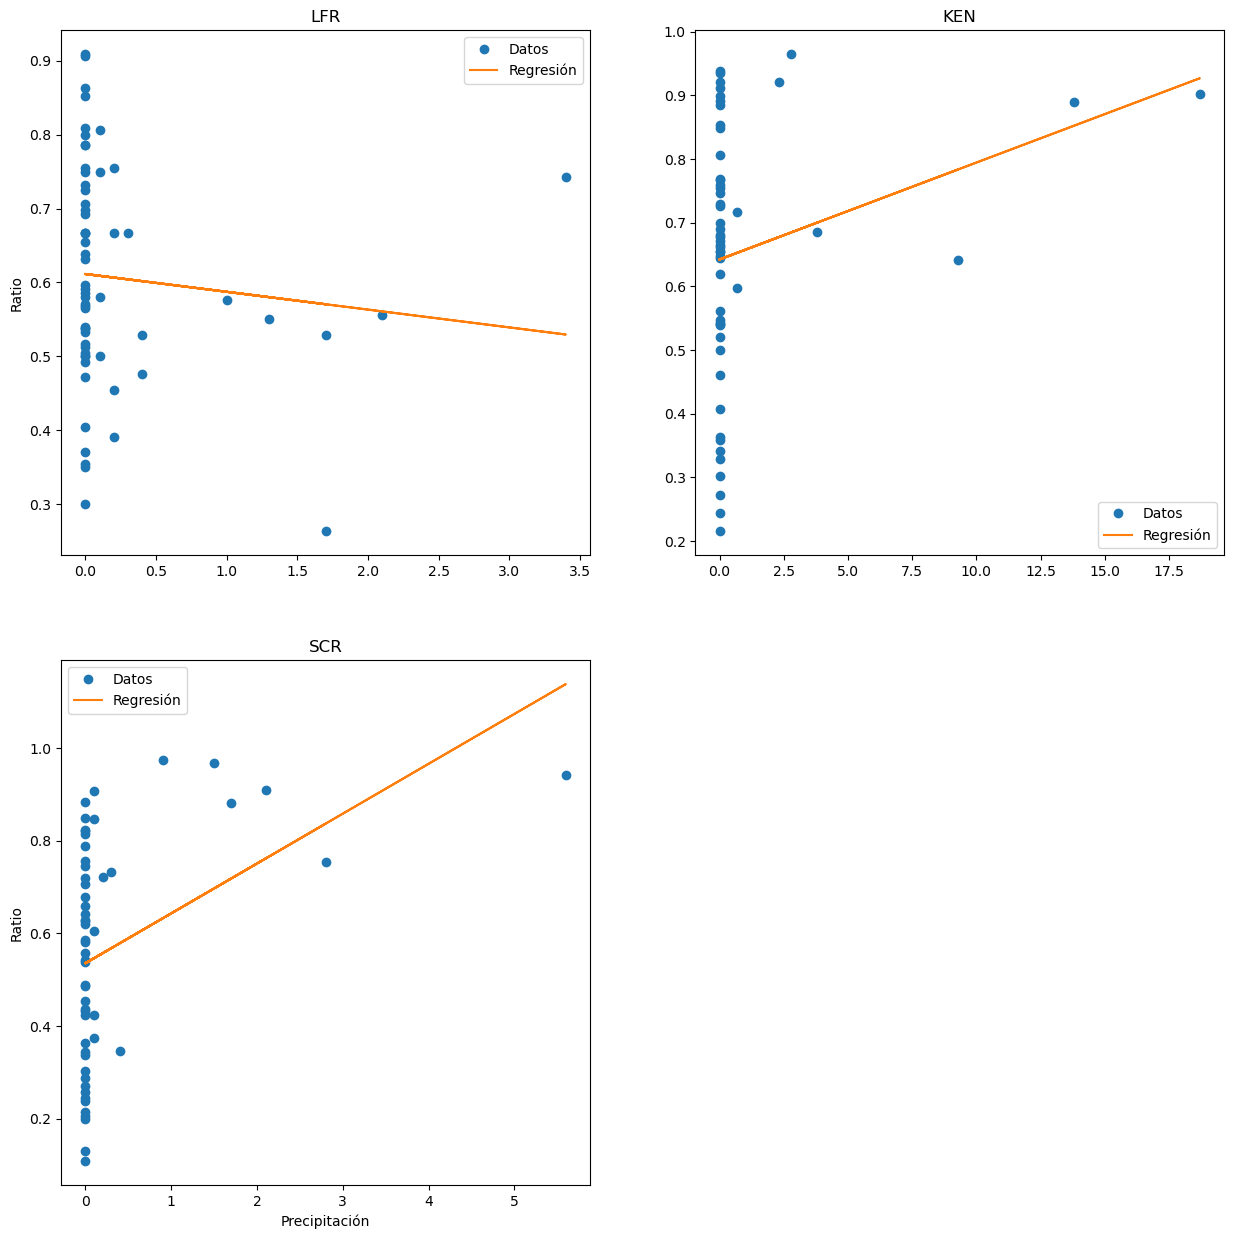

In [ ]:
# Graficamos los datos y las regresiones
fig, ax = plt.subplots(2,2,figsize=(15, 15))

# Quitar los ejes en el cuarto gráfico
ax[1,1].axis('off')

#-----LFR-----#
ax[0,0].plot(datos_LFR["Precipitacion"], datos_LFR["ratio"], 'o', label="Datos")
ax[0,0].plot(datos_LFR["Precipitacion"], datos_LFR["Precipitacion"]*regresion_LFR[0]+regresion_LFR[1], '-', label="Regresión")
ax[0,0].set_title("LFR")
# ax[0,0].set_xlabel("Precipitación")
ax[0,0].set_ylabel("Ratio")
ax[0,0].legend()

#-----KEN-----#
ax[0,1].plot(datos_KEN["Precipitacion"], datos_KEN["ratio"], 'o', label="Datos")
ax[0,1].plot(datos_KEN["Precipitacion"], datos_KEN["Precipitacion"]*regresion_KEN[0]+regresion_KEN[1], '-', label="Regresión")
ax[0,1].set_title("KEN")
# ax[0,1].set_xlabel("Precipitación")
# ax[0,1].set_ylabel("Ratio")
ax[0,1].legend()

#-----SCR-----#
ax[1,0].plot(datos_SCR["Precipitacion"], datos_SCR["ratio"], 'o', label="Datos")
ax[1,0].plot(datos_SCR["Precipitacion"], datos_SCR["Precipitacion"]*regresion_SCR[0]+regresion_SCR[1], '-', label="Regresión")
ax[1,0].set_title("SCR")
ax[1,0].set_xlabel("Precipitación")
ax[1,0].set_ylabel("Ratio")
ax[1,0].legend()


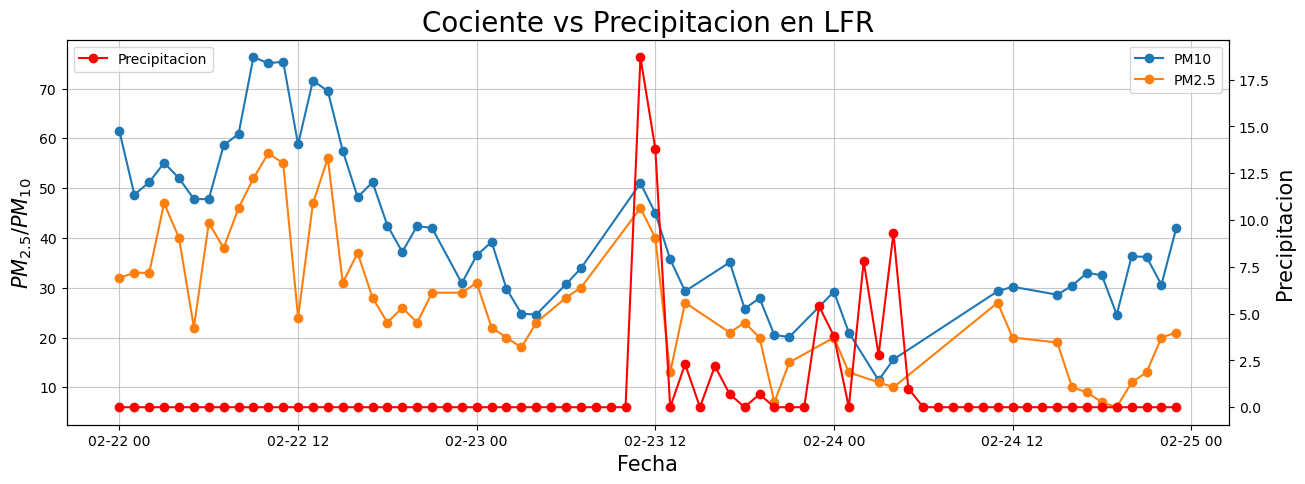

In [ ]:
_="KEN"

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(datos_2020[_]["PM10"]["2020-02-22 00:00:00":"2020-02-24 23:00:00"], "o-", label="PM10")
ax.plot(datos_2020[_]["PM2.5"]["2020-02-22 00:00:00":"2020-02-24 23:00:00"], "o-", label="PM2.5")
# ax.set_ylim(0, 1)
ax.set_ylabel(r"$PM_{2.5}/PM_{10}$", fontsize=15)
ax.set_xlabel("Fecha", fontsize=15)
ax.set_title("Cociente vs Precipitacion en LFR", fontsize=20)
ax.legend()
ax.grid(alpha=0.7)
a = ax.twinx()
a.plot(precipitacion_2020[_]["Precipitacion"]["2020-02-22 00:00:00":"2020-02-24 23:00:00"], "o-", color="red", label="Precipitacion")
a.set_ylabel("Precipitacion", fontsize=15)
a.legend(loc="upper left")
# plt.savefig("ratio_clasification.png", bbox_inches="tight")

## Recycle Bin

In [ ]:
# # importamos los datos de las estaciones y cada DataFrame lo guardamos en un diccionario
# datos = {}
# for i in estaciones:
#     # importamos un set de datos
#     data = pd.read_excel(
#         "../data/2022/" + str(i) + "_2022.xlsx", skiprows=3, skipfooter=11, index_col=0
#     )[["PM10", "PM2.5"]]

#     # eliminamos la fila de unidades
#     data.drop(data.index[0], inplace=True)

#     # cambiamos el indice a tipo fecha, cambiando el 24:00 por 00:00 del otro día
#     data.index = pd.to_datetime(
#         data.index.str.replace("24:00", "00:00"), format="%d-%m-%Y %H:%M"
#     )
#     new_index = []
#     for j in range(len(data.index)):
#         new_index.append(data.index[j])
#         if data.index[j].hour == 0:  # si la hora es 00:00 le sumamos un día
#             new_index[j] = data.index[j] + timedelta(days=1)
#     data.index = new_index

#     # cambiamos el tipo de datos a float
#     data["PM10"] = pd.to_numeric(data["PM10"], errors="coerce")
#     data["PM2.5"] = pd.to_numeric(data["PM2.5"], errors="coerce")

#     # eliminamos los datos nulos
#     data.dropna(inplace=True)

#     # creamos la columna con la relacion PM2.5/PM10
#     data["ratio"] = data["PM2.5"] / data["PM10"]

#     # guardamos el DataFrame con su nombre en el diccionario
#     datos[i] = data

#     # eliminamos todas las entradas en las que el ratio es mayor o igual a 1 y menor o igual a 0
#     datos[i] = datos[i][datos[i]["ratio"] < 1]
#     datos[i] = datos[i][datos[i]["ratio"] > 0]

In [ ]:
# #graficamos un histograma de los datos
# plt.figure(figsize=(10,5))
# plt.hist(data["ratio"], bins=25, edgecolor="black", histtype="bar", color="darkorchid", align= "mid")
# plt.axvline(0.4, color="red", linestyle="dashed")
# plt.axvline(0.6, color="red", linestyle="dashed")
# plt.xlabel("PM2.5/PM10")
# plt.ylabel("Frecuencia")
# plt.title("Histograma de la relación PM2.5/PM10")
# plt.grid(alpha=0.5)
# plt.gca().set_axisbelow(True)
# plt.show()

In [ ]:
# obtenemos la longitud y latitud de cada estacion desde el sitio web de la secretaria de ambiente de bogota
soup = bs.BeautifulSoup(
    requests.get(url).text, "html.parser"
)
coordenadas = {}  # diccionario con las coordenadas de cada estacion [latitud, longitud]
for i in estaciones_2020:

    if i != "MOV1": # MOV1 no aparece en la pagina de la RMCAB
        coordenadas[i] = [
            soup.find("td", string=i).find_next_sibling().text.replace(" ", ""),
            soup.find("td", string=i).find_next_sibling().find_next_sibling().text.replace(" ", ""),
        ]
    elif i == "MOV1":
        coordenadas[i] = ["4°38'42.7\"N", "74°03'41.6\"W"]

# convertimos las coordenadas a float
def convertir_coordenada(coordenada):
    grados, minutos, segundos, direccion = re.split("[°'\"]", coordenada)
    decimal = float(grados) + float(minutos) / 60 + float(segundos) / 3600
    if direccion in ["S", "W"]:
        decimal *= -1
    return decimal

for i in estaciones_2020:
    coordenadas[i][0] = convertir_coordenada(coordenadas[i][0])
    coordenadas[i][1] = convertir_coordenada(coordenadas[i][1])

#graficamos las estaciones en un mapa

fig = go.Figure()
for i in estaciones_2020:
    fig.add_trace(go.Scattermapbox(
        mode="markers",
        lon=[coordenadas[i][1]],
        lat=[coordenadas[i][0]],
        marker={"size": 10, "color": colores.get(clasificacion_2020[i])},
        text=f"{i}: {tipos[clasificacion_2020[i]]}",
    ))

fig.update_layout(
    title_text="Estaciones de la RMCAB",
    mapbox={
        "style": "carto-positron",
        "center": {"lon": -74.08175, "lat": 4.60971},
        "zoom": 10.5,
    },
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    height=600,
    width=800,
    showlegend=True,
)


# #graficamos las estaciones en un mapa
# fig = go.Figure(go.Scattermapbox(
#     mode="markers",
#     lon=[coordenadas[i][1] for i in estaciones_2020],
#     lat=[coordenadas[i][0] for i in estaciones_2020],
#     marker={"size": 10, "color": [colores.get(clasificacion_2020[i]) for i in estaciones_2020]},
#     text=[f"{i}: {tipos[clasificacion_2020[i]]}" for i in estaciones_2020],
# ))

# # Crear una lista de colores y categorías para la leyenda
# leyenda_colores = list(colores.values())
# leyenda_categorias = list(colores.keys())

# # Crear un objeto scattermapbox para la leyenda
# leyenda_trace = go.Scattermapbox(
#     mode="markers",
#     lon=[-74.085, -74.085],  # Coordenadas ficticias para los puntos de la leyenda
#     lat=[4.712, 4.712],
#     marker={"size": 10, "color": leyenda_colores},
#     text=[f"Categoría {tipos[cat]}" for cat in leyenda_categorias],
#     name="Leyenda",
# )

# # Agregar el objeto leyenda_trace al objeto figura principal
# fig.add_trace(leyenda_trace)

# fig.update_layout(
#     title="Clasificación de contaminantes en Bogotá",
#     showlegend=True,
#     mapbox={
#         "style": "carto-positron",
#         'center': {'lon': -74.0820, 'lat': 4.7110}, # centro de bogota
#         "zoom": 9.5,
#     },
#     margin={"l": 0, "r": 0, "t": 0, "b": 0}
# )

# fig.show()

In [ ]:
# array con los nombres de las estaciones
estaciones = ["BOL","CBV","CDAR","COL","CSE","FTB",
            "GYR","JAZ","KEN","LFR","MAM","MOV1",
            "MOV2","PTE","SCR","SUB","TUN","USM","USQ"]

def importar_datos_individuales(estaciones, año):
    # importamos los datos de las estaciones y cada DataFrame lo guardamos en un diccionario
    datos = {}
    for i in estaciones:
        # importamos un set de datos
        data = pd.read_excel(
            "../data/"+str(año)+"/" + str(i) + "_"+str(año)+".xlsx", skiprows=3, skipfooter=11, index_col=0
        )[["PM10", "PM2.5"]]

        # eliminamos la fila de unidades
        data.drop(data.index[0], inplace=True)

        # cambiamos el indice a tipo fecha, cambiando el 24:00 por 00:00 del otro día
        data.index = pd.to_datetime(
            data.index.str.replace("24:00", "00:00"), format="%d-%m-%Y %H:%M"
        )
        new_index = []
        for j in range(len(data.index)):
            new_index.append(data.index[j])
            if data.index[j].hour == 0:  # si la hora es 00:00 le sumamos un día
                new_index[j] = data.index[j] + timedelta(days=1)
        data.index = new_index

        # cambiamos el tipo de datos a float
        data["PM10"] = pd.to_numeric(data["PM10"], errors="coerce")
        data["PM2.5"] = pd.to_numeric(data["PM2.5"], errors="coerce")

        # eliminamos los datos nulos
        data.dropna(inplace=True)

        # creamos la columna con la relacion PM2.5/PM10
        data["ratio"] = data["PM2.5"] / data["PM10"]

        # eliminamos todas las entradas en las que el ratio es mayor o igual a 1 y menor o igual a 0
        data = data[data["ratio"] < 1]
        data = data[data["ratio"] > 0]

        # guardamos el DataFrame con su nombre en el diccionario
        datos[i] = data

    # # calculamos el procentaje de datos que tenemos en cada estacion: datos validos/8600 (8600 horas en un año)
    # porcentaje_datos = {}
    # for i in estaciones:
    #     porcentaje_datos[i] = len(datos[i]) / 8760

    # # descartamos las estaciones que tienen menos del 70% de datos validos
    # estaciones = [i for i in estaciones if porcentaje_datos[i] >= 0.7]
    # datos = {i: datos[i] for i in estaciones}

    return datos

datos2020 = importar_datos_individuales(estaciones, 2020)

In [ ]:
porcentaje_datos = {}
for i in estaciones:
    porcentaje_datos[i] = len(datos2020[i]) / 8760 * 100

#imprimimos la cantidad de estaciones y la cantidad de escaciones con procentaje mayor a 70%
print(f"Estaciones: {len(estaciones)}")
print(f"Estaciones con más del 70% de datos: {len([i for i in estaciones if porcentaje_datos[i] >= 70])}")
porcentaje_datos

Estaciones: 19
Estaciones con más del 70% de datos: 12


{'BOL': 18.972602739726028,
 'CBV': 20.07990867579909,
 'CDAR': 75.68493150684932,
 'COL': 0.0,
 'CSE': 89.41780821917808,
 'FTB': 86.7351598173516,
 'GYR': 81.35844748858447,
 'JAZ': 22.602739726027394,
 'KEN': 92.8082191780822,
 'LFR': 76.07305936073058,
 'MAM': 72.68264840182648,
 'MOV1': 91.9634703196347,
 'MOV2': 0.0,
 'PTE': 81.64383561643835,
 'SCR': 80.3082191780822,
 'SUB': 85.11415525114155,
 'TUN': 91.56392694063928,
 'USM': 19.45205479452055,
 'USQ': 35.61643835616438}

In [ ]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 8))

# Configurar el mapa de Bogotá
mapa = Basemap(projection='lcc', lat_0=4.6097, lon_0=-74.0817,
               resolution="h", area_thresh=0.1,
               llcrnrlon=-74.25, llcrnrlat=4.4,
               urcrnrlon=-73.96, urcrnrlat=4.86
               )
mapa.etopo(scale=0.5, alpha=0.5)
mapa.shadedrelief()

# Dibujar los límites del mapa
mapa.drawcoastlines()
mapa.drawcountries()
mapa.drawstates()
# mapa.fillcontinents(color='lightgray', zorder=0)

# Dibujar líneas de latitud y longitud
mapa.drawparallels(range(4, 5), labels=[1, 0, 0, 0])
mapa.drawmeridians(range(-75, -73), labels=[0, 0, 0, 1])

# Convertir las coordenadas a las coordenadas del mapa
x, y = mapa(np.array([coordenadas[i][1] for i in estaciones]), np.array([coordenadas[i][0] for i in estaciones]))


# Dibujar los puntos en el mapa
for i, categoria in enumerate(clasificaciones.values()):
    ax.scatter(x[i], y[i], color=colores[categoria], marker='o', s=50)

# Mostrar el gráfico
plt.show()

Unnamed: 0   PM10  PM2.5 PM10.1 PM2.5.1 PM10.2 PM2.5.2 PM10.3  \
0                  NaN  µg/m3  µg/m3  µg/m3   µg/m3  µg/m3   µg/m3  µg/m3   
1     01-01-2021 01:00   59.6   34.6    150     109   21.6    21.6   ----   
2     01-01-2021 02:00     96   59.6    179     145   30.9      25   ----   
3     01-01-2021 03:00   96.3   62.7    235     188   35.7    ----   ----   
4     01-01-2021 04:00    108     64     52      42   42.2    ----   ----   
...                ...    ...    ...    ...     ...    ...     ...    ...   
8767           MaxTime  17:00  23:00  02:00   03:00  09:00   11:00  22:00   
8768               Avg   33.2   14.3   68.5    34.6   21.7    12.2   17.6   
8769               Num   8564   8665   7524    7402   7843    8557   6635   
8770       DataPrecent   97.8   98.9   85.9    84.5   89.5    97.7   75.7   
8771               STD   19.4    9.1   34.0    17.4   14.0     9.6   10.1   

     PM2.5.3 PM10.4  ... PM10.10 PM2.5.10 PM10.11 PM2.5.11 PM10.12 PM2.5.12  \
0      µg/m3  µg/m3  ...   µg/m3    µg/m3   µg/m3    µg/m3   µg/m3    µg/m3   
1       ----   40.3  ...    36.7       23      53       49    ----     ----   
2       ----   92.5  ...    36.6       36      35       14    ----     ----   
3       ----   68.3  ...      50       50      17       17    ----     ----   
4       ----   61.3  ...    ----       54      52       47    ----     ----   
...      ...    ...  ...     ...      ...     ...      ...     ...      ...   
8767   18:00  08:00  ...   06:00    04:00   10:00    10:00   07:00    22:00   
8768     7.8   32.3  ...    32.2     20.2    20.4     11.4    29.7     12.6   
8769    6771   8023  ...    6784     7977    8172     8443    8025     8313   
8770    77.3   91.6  ...    77.4     91.1    93.3     96.4    91.6     94.9   
8771     6.5   20.9  ...    19.6     14.7    16.6     11.0    16.8      8.9   

     PM10.13 PM2.5.13 PM10.14 PM2.5.14  
0      µg/m3    µg/m3   µg/m3    µg/m3  
1       ----      140    16.8       13  
2        183      143    11.7     ----  
3        186      171    15.4     11.2  
4        204       23     8.8      7.6  
...      ...      ...     ...      ...  
8767   04:00    03:00   07:00    14:00  
8768    34.6     13.4    19.6     10.4  
8769    8569     8360    4911     4842  
8770    97.8     95.4    56.1     55.3  
8771    24.9     12.1    13.5      8.9  

[8772 rows x 31 columns]